In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from wpca import WPCA
#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import re
import os
from datetime import date
import mygene         #for alternative method of changing ensembl names to gene symbols
mg = mygene.MyGeneInfo()
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from porch import porch
from urllib.error import HTTPError, URLError
import time
import sys
from random import sample

/home/augjan/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data preparation

In [18]:
def drop(df, col, key):
    '''
    Fuction to make it possible to drop rows of a dataframe (df) with a specific list as condition (key) in a specific column (col)
    '''
    m = [v == key for v in df[col]]
    df.loc[m, col] = float('NaN')
    df.dropna(inplace=True)
    return df

def TFs_targets(kbp, chip, MACS2, MAX): 
    '''
    Function for creating csv with all TFs and their target genes. For each TF, it identifies urls for target gene data, fetches the info and puts it into a list that is then converted to a dataframe as output
    '''
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                TF_gene_set =  pd.read_csv(url, sep='\t', index_col='Target_genes') #For a specific TF, read csv from url as a dataframe
                col = list(TF_gene_set.columns)
                for i in range(len(col)-2):
                    col[i+1] = col[i+1].split('|',1)[1]
                TF_gene_set.columns = col
                TF_set = pd.DataFrame(index=TF_gene_set.index, columns=set(col[1:-1]))
                for sample in TF_set.columns:
                    TF_set[sample] = TF_gene_set.loc[:,[sample]].mean(axis=1)
                TF_set['Max'] = TF_set.max(axis=1)
                genes = TF_set.loc[(TF_set > MACS2).sum(axis=1)>0,:].nlargest(n=MAX, columns='Max').index.tolist()
                TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs   
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                genes = []
                TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1

    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.drop(TF_gene_sets[TF_gene_sets.Genes == '[]'].index, inplace=True)
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(MACS2)+'+MACS2_'+str(kbp)+'kbp.tsv', sep='\t')

    return TF_gene_sets

def TFs_targets_strict_porch(kbp, MACS2, chip): 
    '''
    Function for creating csv with all TFs and a strict selection of their potential target genes. For each TF, 
    it identifies urls for target genedata, fetches the info and puts genes with a high enough MACS2 and STRING
    binding score into a list that is then converted to a dataframe as output
    '''
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                TF_gene_set = pd.read_csv(url, sep='\t', index_col='Target_genes') #For a specific TF, read csv from url as a dataframe
                genes = str(TF_gene_set.loc[(TF_gene_set > 700).sum(axis=1)>0,:].reset_index()['Target_genes'].tolist()).replace("'","") #['Target_genes'] #Take the contents of column 'Target_genes' and puts it into a list for rows with a value above set MACS2 threshold
                TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                genes = []
                TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets = drop(TF_gene_sets, 'Genes', '[]')
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_porch_'+str(kbp)+'_'+str(MACS2)+'.tsv', sep='\t')
    return TF_gene_sets

def Bigdict(kbp):
    '''
    Function for creating a dictionary of the data from ChIP-atlas so that gene sets can be created from
    different restrictions can be created without having to dowload the data each time.
    '''
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')
    
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    bigdict = {}
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                bigdict[chip.index[dex]] = pd.read_csv(url, sep='\t', index_col='Target_genes') #For a specific TF, read csv from url as a dataframe
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                bigdict[chip.index[dex]] = pd.DataFrame()
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1
    return bigdict
    
def TF_targets_dict(bigdict, MACS2, MAX, kbp):
    '''
    Function for creating gene sets with the data from Bigdict.
    '''
    TF_gene_list = []

    for TF in bigdict:
        TF_gene_set = bigdict[TF].copy()
        col = list(TF_gene_set.columns)
        for i in range(len(col)-2):
            col[i+1] = col[i+1].split('|',1)[1]
        TF_gene_set.columns = col
        TF_set = pd.DataFrame(index=TF_gene_set.index, columns=set(col[1:-1]))
        for sample in TF_set.columns:
            TF_set[sample] = TF_gene_set.loc[:,[sample]].mean(axis=1)
        TF_set['Max'] = TF_set.max(axis=1)
        genes = TF_set.loc[(TF_set > MACS2).sum(axis=1)>0,:].nlargest(n=MAX, columns='Max').index.tolist()
        TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs   
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=bigdict.keys()) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.index.name = 'Antigen'  
    TF_gene_sets.drop(TF_gene_sets[TF_gene_sets.Genes.astype(str) == '[]'].index, inplace=True)
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(MACS2)+'+MACS2_'+str(kbp)+'kbp.tsv', sep='\t')

def ID_to_symbol(datatsv): 
    '''
    Function for replacing the ensenbl gene IDs with gene symbols/names in dataframe with expression data
    '''
    dataset = pd.read_csv(datatsv, sep='\t') 
    symbols = pd.read_csv('../data/Gene_names.txt', index_col='Gene stable ID')
    symbols = symbols.drop_duplicates(keep=False)
    dataset = dataset.merge(symbols, left_on='Gene', right_on='Gene stable ID', how = 'left')
    dataset.dropna(how='any', inplace=True)
    dataset.set_index('Gene name', inplace=True)
    dataset.drop(columns='Gene', inplace=True)
    dataset.index.rename('Symbol', inplace=True)
    dataset.to_csv('../data/genes.raw.htseq2.symbols.tsv', sep='\t')
    return dataset

def ID_to_symbolMG(datatsv):
    '''
    Alternative function for replacing the ensembl gene IDs with gene symbols/names in expression data, using MyGene package.
    '''
    dataset = pd.read_csv(datatsv, sep='\t')
    genes = dataset.loc[:,'Gene']
    genesyms = mg.querymany(genes, scopes='ensembl.gene', fields='symbol', as_dataframe=True) #Look up gene symbols with mygene
    genesyms = genesyms.dropna(subset=['symbol'], how='any') #Drop genes where no gene symbol was identified
    genesyms = genesyms.loc[~genesyms.index.duplicated(keep=False)] #Drop genes for which multiple gene symbols were identified
    syms = genesyms.loc[:,'symbol']
    dataset = dataset.merge(syms, left_on='Gene', right_on='query', how = 'left')
    dataset.dropna(how='any', inplace=True)
    dataset.set_index('symbol', inplace=True)
    dataset.index.rename('Symbol',inplace=True)
    dataset.drop(columns='Gene', inplace=True)
    dataset.to_csv('../data/genes.raw.htseq2.symbolsMG.tsv', sep='\t')
    return dataset

def csv_fix(csv):
    '''
    Function that opens a csv file and removes quotes at the end and beginning of rows with quotes in them,
    and converst double quotes to single quotes.
    (The original chip_atlas_analysis_list.csv that was downloaded did not work,
    as it contained an extra '"' in the start and end of each row with '"' in it, and each '"' had an extra  '"')
    '''
    name, ext = os.path.splitext(csv)
    newfilename = '{name}_{add}{ext}'.format(name=name, add='CORRECTED', ext='.csv')
    with open(csv,'r+') as csv_file:
        for line in csv_file:
            # removing starting and ending quotes of a line
            pattern1 = re.compile(r'^"|"$',re.MULTILINE)
            line = re.sub(r'^"|"$',"",line)
            # substituting escaped quote with a single quote
            pattern2 = re.compile(r'""')
            line = re.sub(r'""','"',line)
            corrected_csv = open(newfilename,'a')
            corrected_csv.write(line)
            corrected_csv.close()
    csv_df = pd.read_csv(newfilename, quotechar = '"')
    return csv_df

def gene_sets(kbp, MACS2, MAX):
    '''
    Fetch data on which genes may be regulated by each TF.
    '''
    # Read csv with all all TFs and urls to files with their target genes
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')

    #Read csv with TFs and their target genes. If not available, fetch the data and create a csv
    try: 
        TF_gene_sets = pd.read_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(MACS2)+'+MACS2_'+str(kbp)+'kbp.tsv', sep='\t', index_col='Antigen', converters={'Genes': lambda x: x.strip('[]').replace("'","").split(', ')})
    except FileNotFoundError:
        TF_gene_sets = TFs_targets(kbp,chip,MACS2,MAX)
        
    return TF_gene_sets

    
def gene_sets_porch(kbp, MACS2):
    '''
    Fetch data on which genes may be regulated by each TF.
    '''
    # Read csv with all all TFs and urls to files with their target genes
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')

    #Read csv with TFs and their target genes. If not available, fetch the data and create a csv
    try: 
        TF_gene_sets = pd.read_csv('../data/Transfactors/TF_gene_sets_porch_'+str(kbp)+'_'+str(MACS2)+'.tsv', sep='\t', index_col='Antigen')
    except FileNotFoundError:
        TF_gene_sets = TFs_targets_strict_porch(kbp, MACS2, chip)
        
    #Pick out gene sets with 500 or fewer genes
    TF_short_sets = TF_gene_sets.copy()
    for TF in TF_short_sets.index:
        if len(TF_short_sets.loc[TF,:][0]) > 500:
            TF_short_sets.drop([TF], inplace=True)
    return TF_gene_sets

def data_set():
    '''
    Fetch the longitudinal mRNA expression data and the sample specifications
    '''
    #Read in dataset with expression values and gene symbols. If not available, replace ensembl IDs and create the csv
    try:
        dataset = pd.read_csv('../data/genes.raw.htseq2.symbols.tsv', sep='\t', index_col='Symbol')
    except:
        ID_to_symbol('../data/genes.raw.htseq2.tsv')

    #Read in dataset with sample sepcifications
    dataset2 = pd.read_csv('../data/E-MTAB-2328.sdrf.tsv', sep='\t') #Read csv with specifications of assays
    return dataset, dataset2

def indexing(dataset, dataset2):
    '''
    Function that creates a dataframe with multi-colunindex of organ and developmental stage, index is genes
    '''
    #Exctract important characteristincs of samples from dataset2
    chars = pd.DataFrame()
    chars['assay'] = dataset2.loc[:,'Assay Name'].str.slice(stop=6)
    #chars['dev_stage'] = dataset2.loc[:,'Characteristics[developmental stage]']
    chars['organ'] = dataset2.loc[:,'Characteristics[organism part]']
    chars = chars.drop_duplicates()
    chars['dev_stage'] = [-5.5,-5.5,-2.5,-2.5,0.5,0.5,4,4,22,22,29,29,-5.5,-5.5,-2.5,-2.5,0.5,0.5,4,4,22,22,29,29]
    chars = chars.set_index('assay')

    #Insert the important characteristics into dataset with expression values as column index
    datasetT = dataset.T
    datasetT['dev_stage'] = datasetT.index.to_series().map(chars['dev_stage'])
    datasetT['organ'] = datasetT.index.to_series().map(chars['organ'])
    datasetT.set_index(['organ','dev_stage'], inplace=True)
    #expdata = datasetT.sort_index(level = 0).T
    expdata = datasetT.T
    return expdata

def component_removal(data, n_comp):
    mean = data.mean(axis=1)
    data = data.sub(mean, axis=0)
    
    dataT = data.T.values
    
    weights = 0 + np.isfinite(dataT)
    kwds = {'weights': weights}
    
    pca = WPCA(n_components = 30).fit(dataT,**kwds) #Fit data to model

    reconstruction = np.dot(pca.transform(dataT)[:,n_comp:], pca.components_[n_comp:,:])
    reconst_df = pd.DataFrame(data=reconstruction.T, columns=data.columns, index=data.index)
    reconst_df = reconst_df.add(mean,axis=0)
    
    return reconst_df

### Analysis of full data

In [4]:
def heatmap(PCAdata, expdata, TF_gene_sets):
    '''
    Experimental function that for a specific TF is supposed to create a heatmap describing how the transcription
    of all genes in the gene set has changed over time, as well as how the PC 'activity changes over time so the 
    two can be compared visually.
    '''
    TF = TF_gene_sets.index[25] 
    genesIndex = pd.DataFrame(TF_gene_sets.loc[TF,'Genes'], columns=['Genes'])
    genesIndex.set_index('Genes', inplace=True)  
    genes = genesIndex.index.intersection(expdata.index)
    TFdata = expdata.loc[genes,'liver']
    PCA = pd.DataFrame(PCAdata.loc['liver',TF])
    x = TFdata.shape[0]
    fig, (ax0,ax1) = plt.subplots(2,1, sharex=True, figsize=(8,1+x), gridspec_kw={'height_ratios': [1,x]})
    g1 = sns.heatmap(PCA.T, cbar=False, ax=ax0, square=True, linewidths=1, linecolor='black')
    g2 = sns.heatmap(TFdata, cbar=False, ax=ax1, square=True, linewidths=1, linecolor='black')
    ax0.set_xlabel('')
    fig.tight_layout()
    
def expmean(expdata):
    
    means = []
    means.append(expdata.loc[:,'-5'].mean())
    means = pd.DataFrame(index=expdata.columns)
    
    
def genesethist(df, xlim=500):
    '''
    Funciton for creating a histogram showing the size distribution of TF gene sets
    '''
    print('Dataset contains '+str(df.shape[0])+' TFs')
    print('Dataset contains '+str(df.loc[df['Gene count'] == 1].shape[0])+' TF(s) with only a single gene')
    bins = np.linspace(0,xlim, 51)
    plt.figure(figsize=(16,8))
    plt.xlabel('Number of genes')
    plt.ylabel('Numberr of TFs')
    axes = plt.gca()
    axes.set_xlim([0,xlim])
    plt.hist(df.loc[:,'Gene count'], bins)
    
    plt.show()

def fewgenesethist(df):
    '''
    Funciton for creating a histogram showing the size distribution of TF gene sets with 500 or fewer genes
    '''
    bins = np.linspace(0,500, 51)
    plt.figure(figsize=(16,8))
    plt.hist(df.loc[:,'Gene count'], bins)
    axes = plt.gca()
    axes.set_xlim([0,500])
    plt.xlabel('Number of genes')
    plt.ylabel('Number of TFs')
    plt.xlim=[0,500]
    print('Dataset contains '+str(df.loc[df['Gene count'] <= 500].shape[0])+' TF(s) with 500 or fewer genes')
    plt.show()
    
def varexplplot(df,PC=1, xlim=500):
    '''
    Function to plot the variance explained by the first PC against nr of genes in the gene set
    '''
    plt.figure(figsize=(16,8))
    plot = sns.scatterplot(x='Gene count', y='Variance explained PC'+str(PC), data=df, s=20)
    plot.set(ylim=(0,1))
    plot.set(xlim=(0,xlim))
    plt.xlabel('Number of genes')
    plt.show()
#    save_fig(plt,'Variance',str(xlim))
    
def varregplot(df):
    df = df.loc[df['Gene count']>=100]
    plt.figure(figsize=(16,8))
    plot = sns.regplot(x='Gene count', y='Variance explained PC1', data=df, scatter_kws={'s':2})
    plot.set(ylim=(0,1))
    plot.set(xlim=(100,16000))
    plt.xlabel('Number of genes')
    plt.title('Linear regression for TFs with >=100 genes')
    plt.show()
    
def PCplot(dfs, hue='organ', size=None, style=None, ax=None):
    plt.figure(figsize=(16,16))
    PC1 = pd.DataFrame()
    PC2 = pd.DataFrame()
    org = pd.DataFrame()
    stage = pd.DataFrame()
    for TF in dfs['PC1'].columns:
        PC1 = pd.concat([PC1, dfs['PC1'].reset_index().loc[:,TF]])
        PC2 = pd.concat([PC2, dfs['PC2'].reset_index().loc[:,TF]])
        org = pd.concat([org, dfs['PC1'].reset_index().loc[:,'organ']])
        stage = pd.concat([stage, dfs['PC1'].reset_index().loc[:,'dev_stage']])
    PCS = pd.concat([PC1,PC2,org,stage], axis=1)
    PCS.columns = ['PC1','PC2','organ','stage']
    plot = sns.scatterplot(x='PC1', y='PC2', hue=hue, size=size, style=style, data=PCS, legend='full', ax=ax)
    if ax == None:
        plt.show()
    else:
        return plot
    
def PCplot2(dfs, hue='stage', ax=None):
    plt.figure(figsize=(16,16))
    PC1 = pd.DataFrame()
    PC2 = pd.DataFrame()
    org = pd.DataFrame()
    stage = pd.DataFrame()
    for TF in dfs['PC1'].columns:
        PC1 = pd.concat([PC1, dfs['PC1'].reset_index().loc[:,TF]])
        PC2 = pd.concat([PC2, dfs['PC2'].reset_index().loc[:,TF]])
        org = pd.concat([org, dfs['PC1'].reset_index().loc[:,'organ']])
        stage = pd.concat([stage, dfs['PC1'].reset_index().loc[:,'dev_stage']])
    PCS = pd.concat([PC1,PC2,org,stage], axis=1)
    PCS.columns = ['PC1','PC2','organ','stage']
    PCS.set_index('organ', inplace=True)
    PCSl = PCS.loc['liver',:]
    PCSb = PCS.loc['brain',:]
    plot = sns.scatterplot(x='PC1', y='PC2', hue=hue, palette='ch:start=2.7,rot=0.1,dark=0.4,light=0.8', data=PCSb, legend='full', ax=ax)
    plot = sns.scatterplot(x='PC1', y='PC2', hue=hue, palette='ch:start=1.7,rot=0.1,dark=0.4,light=0.8', data=PCSl, legend='full', ax=ax)
    if ax == None:
        plt.show()
    else:
        return plot

def PCplot3(dfs, hue='stage', size=None, style=None, ax=None):
    plt.figure(figsize=(16,16))
    PC1 = pd.DataFrame()
    PC2 = pd.DataFrame()
    org = pd.DataFrame()
    stage = pd.DataFrame()
    for TF in dfs['PC1'].columns:
        PC1 = pd.concat([PC1, dfs['PC1'].reset_index().loc[:,TF]])
        PC2 = pd.concat([PC2, dfs['PC2'].reset_index().loc[:,TF]])
        stage = pd.concat([stage, dfs['PC1'].reset_index().loc[:,'dev_stage']])
    PCS = pd.concat([PC1,PC2,stage], axis=1)
    PCS.columns = ['PC1','PC2','stage']
    display(PCS)
    plot = sns.scatterplot(x='PC1', y='PC2', hue=hue, size=size, style=style, data=PCS, legend='full', ax=ax)
    if ax == None:
        plt.show()
    else:
        return plot
    
def datacheck(kbp, MACS2, MAX, organ=None):
    '''
    Main function for checking data distribution
    '''
    TF_gene_sets = gene_sets(kbp, MACS2, MAX)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    logdata = log2trans(expdata)
    if organ != None:
        logdata = logdata.loc[:,organ]
    TF_gene_sets.loc['All','Genes'] = list(logdata.index[:])
    Other_results = pd.DataFrame(index=TF_gene_sets.index)
    [PCA_per_TF, Other_results, Contributions] = run_PCA(logdata, TF_gene_sets,Other_results,2,PCA_func=normal_PCA)
    full = Other_results.loc['All',:]
    genesethist(Other_results.drop(['All']))
    fewgenesethist(Other_results.drop(['All']))
    print('The first PC from PCA for full genome with '+str(int(full['Gene count']))+' genes explained '+str(full['Variance explained PC1']*100)+'% of variance in the full dataset.')
    varexplplot(Other_results.drop(['All']))
    #    varregplot(Other_results.drop(['All']))
    PCplot(PCA_per_TF)
    PCplot2(PCA_per_TF)

    return TF_gene_sets, Contributions

def datacheck2(kbp, MACS2, MAX, n_pc=2,organ=None):
    '''
    Main function for checking data distribution
    '''
    TF_gene_sets = gene_sets(kbp,MACS2,MAX)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    expdata = expdata/(expdata.sum()/10**6) #Reads/transcripts per million normalization    
    expdata.replace(0,float('NaN'), inplace=True) #Remove 0-values for log transformation
    expdata.dropna(inplace=True)
    
    logdata = np.log2(expdata)
    
    if organ != None:
        logdata = logdata.loc[:,organ]
        
    Other_results = pd.DataFrame(index=TF_gene_sets.index)
    [PCA_results, Other_results, Contributions] = run_PCA(logdata,TF_gene_sets,Other_results, n_pc,PCA_func=normal_PCA)

    genesethist(Other_results, xlim=MAX)
    varexplplot(Other_results, xlim=MAX)
    varexplplot(Other_results, xlim=MAX, PC=2)

    if organ == None:
        fig, axes = plt.subplots(1,2, figsize=(32,16))
        PCplot(PCA_results, ax=axes[0])
        PCplot2(PCA_results, ax=axes[1])
    else:
        PCplot3(PCA_results)

    return TF_gene_sets, Contributions

def PCcheck(kbp, MACS2, genelim, organ=None):
    TF_gene_sets = gene_sets(kbp, MACS2)
    TF_gene_sets_res = TF_gene_sets.copy()
    for TF in TF_gene_sets_res.index:
        if len(TF_gene_sets_res.loc[TF,:][0])>genelim or len(TF_gene_sets_res.loc[TF,:][0])<2:
            TF_gene_sets_res.drop(TF,inplace=True)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    logdata = log2trans(expdata)
    if organ != None:
        logdata = logdata.loc[:,organ]

    Other_results = pd.DataFrame(index=TF_gene_sets.index)
    Other_results_res = pd.DataFrame(index=TF_gene_sets_res.index)

    [PCA_per_TF, Other_results, Contributions] = run_weighted_pca(logdata, TF_gene_sets,Other_results,2)
    [PCA_per_TF_res, Other_results_res, Contributions_res] = run_weighted_pca(logdata, TF_gene_sets_res,Other_results_res,2)
    fig, axes = plt.subplots(2,2, figsize=(32,32)) #, gridspec_kw={'height_ratios': [1,x]})
    
    PCplot(PCA_per_TF, ax=axes[0,0])
    PCplot2(PCA_per_TF, ax=axes[0,1])
    PCplot(PCA_per_TF_res, ax=axes[1,0])
    PCplot2(PCA_per_TF_res, ax=axes[1,1])
    plt.show()
    #save_fig(fig,'PC','check')

def checkdatacheck():
    data = pd.DataFrame()
    for i in range(300,1200,100):
        TF_gene_sets = gene_sets(10,i)
        length = pd.DataFrame(index=TF_gene_sets.index, columns=['Genes'])
        for TF in TF_gene_sets.index:
            length.loc[TF:,'Genes'] = len(TF_gene_sets.loc[TF,:][0])
        data.loc[i,'TFs'] = length.shape[0]
        data.loc[i,'TFs 1-500'] = length.loc[length['Genes'] <= 500].shape[0]
        data.loc[i,'TFs 2-500'] = data.loc[i,'TFs 1-500']-length.loc[length['Genes'] == 1].shape[0]
    return data

def contplot():
    bins = np.linspace(0,max(cont.loc[:,'Contribution']), 50)
    plt.hist(cont.loc[:,'Contribution'], bins)#, , alpha=0.5, label=variable)
    plt.xlabel('% contribution to PC1')
    plt.ylabel('Nr of genes')
    plt.title(TF)
    plt.show()
    


### Perform PCA and show results

In [28]:
def normal_PCA(df, n_pc=1, standardize=True):
    '''
    Function for performing the PCA, using sklearn. 
    
    df - Dataframe with expression values
    '''
    x = df.values.T #Set x as transpose of only the numerical values of the dataframe
    if standardize:
#        x = x-x.mean()
#        x2 = x/x.std()
        standardizer = StandardScaler()
        x2 = standardizer.fit_transform(x) #Standardize the data (center to mean and scale to unit variance)
        
#        x2 = preprocessing.scale(x) #Standardize the data (center to mean and scale to unit variance)
    else:
        x2 = x
        
    x2 = np.nan_to_num(x2) #Change back NaN values to 0, so array is accepted by the PCA function
    

    n_pcs = min(df.shape[0],n_pc)
    pca = PCA(n_components = n_pcs).fit(x2) #Set PCA parameters
    expl = pca.explained_variance_ratio_
    x3 = pca.transform(x2) #Transform the data (apply dimensionality reduciton) and set x3 as principal components 
    out_df = pd.DataFrame(x3.T, index=list(range(1,n_pcs+1)), columns=df.columns).T #Create dataframe with vlues from the PCA and set columnindex as the PC number 

    cont = pd.DataFrame(index=df.index)
    for i in range(n_pcs):
        cont.loc[:,'PC{0} contribution'.format(i+1)] = pca.components_[i]**2
    cont.sort_values(by='PC1 contribution', ascending=False, inplace=True)
        
    while n_pcs < n_pc:
        expl = np.append(expl,float('NaN'))
        n_pcs += 1
        out_df.loc[:,str(n_pcs)] = float('NaN')

    return out_df, expl, cont

def weighted_PCA(df, n_pc=1, standardize=True):
    '''
    Function for performing the PCA, using sklearn. 
    
    df - Dataframe with expression values
    '''
    x = df.values.T #Set x as transpose of only the numerical values of the dataframe
    if standardize:
#        x = x-x.mean()
#        x2 = x/x.std()
        standardizer = StandardScaler()
        x2 = standardizer.fit_transform(x) #Standardize the data (center to mean and scale to unit variance)
        
#        x2 = preprocessing.scale(x) #Standardize the data (center to mean and scale to unit variance)
    else:
        x2 = x
        
    x2 = np.nan_to_num(x2) #Change back NaN values to 0, so array is accepted by the PCA function
    
    weights = 0 + np.isfinite(x)
    kwds = {'weights': weights}
    display(weights.shape)
    n_pcs = min(df.shape[0],n_pc)
    #pca = PCA(n_components = n_pcs) #Set PCA parameters
    pca = WPCA(n_components = n_pcs).fit(x2,**kwds) #Fit data to model
    expl = pca.explained_variance_ratio_
    x3 = pca.transform(x2,**kwds) #Transform the data (apply dimensionality reduciton) and set x3 as principal components 
    out_df = pd.DataFrame(x3.T, index=list(range(1,n_pcs+1)), columns=df.columns).T #Create dataframe with vlues from the PCA and set columnindex as the PC number 

    cont = pd.DataFrame(index=df.index)
    for i in range(n_pcs):
        cont.loc[:,'PC{0} contribution'.format(i+1)] = pca.components_[i]**2
    cont.sort_values(by='PC1 contribution', ascending=False, inplace=True)
        
    while n_pcs < n_pc:
        expl = np.append(expl,float('NaN'))
        n_pcs += 1
        out_df.loc[:,str(n_pcs)] = float('NaN')

    return out_df, expl, cont

def run_PCA(expdata, TF_gene_sets, Other_results, n_pc=1, PCA_func=weighted_PCA):
    '''
    Function that uses selected PCA on supplied dataframe
    '''
    PCA_per_TF = {}
    Contributions = {}
    for i in range (n_pc):
        PCA_per_TF['PC{0}'.format(i+1)] = pd.DataFrame(index=expdata.columns)
    for TF in TF_gene_sets.index: 
        genesIndex = pd.DataFrame(TF_gene_sets.loc[TF,'Genes'], columns=['Genes'])
        genesIndex.set_index('Genes', inplace=True)  
        genes = genesIndex.index.intersection(expdata.index)
        if len(genes)>2:
            TFdata = expdata.loc[genes,:]
            [res, expl, cont] = PCA_func(TFdata, n_pc)
            Contributions[TF] = cont
            for i in range(n_pc):
                PCA_per_TF['PC{0}'.format(i+1)][TF] = res.iloc[:,i]
                PCA_per_TF[TF] = res.iloc[:,0]
                Other_results.loc[TF,'Gene count'] = len(genes)
                Other_results.loc[TF,'Variance explained PC'+str(i+1)] = expl[i]
        else:
            print(TF+' has less than 3 genes associated with it and is therefore disregarded.')
            Other_results.drop(TF)
    for i in range (n_pc):
        PCA_per_TF['PC{0}'.format(i+1)].sort_index(inplace=True)
    return PCA_per_TF, Other_results, Contributions

def save_exp(data, filename):
    '''
    Save data from performed experiments as tsv file in a date-specific subfolder of exp
    '''
    if os.path.isdir('../exp/'+str(date.today())) == False:
        os.mkdir('../exp/'+str(date.today()))
    data.to_csv('../exp/'+str(date.today())+'/'+filename+'.tsv', sep='\t')
        
def save_fig(figure, A, B):
    '''
    Save a figure as a png in a date-specific subfolder of exp
    '''
    if os.path.isdir('../exp/'+str(date.today())) == False:
        os.mkdir('../exp/'+str(date.today()))
    figure.savefig('../exp/'+str(date.today())+'/'+A+'_'+B+'_plot.png', bbox_inches="tight")

def activityplot(TF_list, PCA_results, logdata, organ='', hue=None, style=None):
    '''
    Function for plotting TF principal component and gene expression over time
    '''
    PCA_results = -PCA_results
    for TF in TF_list.dropna().index:
        fig, axes = plt.subplots(1,2, figsize=(32,16)) #, gridspec_kw={'height_ratios': [1,x]})
        #Plot the combined PC expression for TFs in list
        PC_plot = sns.lineplot(x='dev_stage', y=TF, hue=hue, style=style, data=PCA_results.reset_index(), ax=axes[0])        
        axes[0].set_xlabel('Developmental stage (days)')
        axes[0].set_ylabel('Log2 expression')
        axes[0].set_title(TF+' PC expression'+organ)
        #Plot the gene expression for the TFs in list
        Gene_plot = sns.lineplot(x='dev_stage', y=TF, hue=hue, style=style, data=logdata.T.sort_index().reset_index(), ax=axes[1])
        axes[1].set_xlabel('Developmental stage (days)')
        axes[1].set_ylabel('Log2 expression')
        axes[1].set_title(TF+' gene expression'+organ)
        save_fig(plt,TF,organ)
    plt.show()
    
def TF_selection(logdata, TF_gene_sets, which='',n=5):
    '''
    Function for selecting TFs with high and varying gene expression for the first test of the method
    '''
    genes = TF_gene_sets.index.intersection(logdata.index) #Find genes/TFs found both in expression data and list of TFs
    if which == 'Random':
        genes = sample(list(genes),n)
    elif which == 'Top':
        logdata = logdata.loc[genes,:] #Pick out expression data for "genes"
        mean = logdata.mean().mean() #Find overall mean of all selected genes
        for gene in logdata.index:
            if logdata.loc[gene,:].mean()<mean: #Remove genes with a mean expression below that of the full data
                logdata.drop(gene, inplace=True)
            else:
                logdata.loc[gene,'Variance'] = np.var(logdata.loc[gene,:])
        logdata.sort_values(by='Variance', inplace=True)
        genes = logdata.nlargest(n=n, columns='Variance').index.tolist()
    return genes    

def dataprep(kbp,MACS2, MAX, n_pc=1, PC=1, organ=None, which='', remove=None,filtering='remove0'):
    TF_gene_sets = gene_sets(kbp,MACS2,MAX)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    expdata = expdata/(expdata.sum()/10**6) #Reads/transcripts per million normalization    
    
    if filtering=='remove0':
        expdata.replace(0,float('NaN'), inplace=True) #Remove 0-values for log transformation
        expdata.dropna(inplace=True)
        
    elif filtering=='remove25%0':
            print('Removing genes with expression in <25% of samples...')
        lim = expdata.shape[1]*0.25
        for gene in expdata.index: #Remove genes for which >25% of samples had no expression
            if expdata.loc[gene,:].tolist().count(0) > lim:
                expdata.drop(gene, inplace=True)
        print('Done')
        print(expdata.shape)

        expdata = expdata + 1 #Prepare 0-values for log transformation
    
    logdata = np.log2(expdata)
    
    if organ != None:
        logdata = logdata.loc[:,organ]    
        
    if remove != None:
        logdata = component_removal(logdata, remove)
    
    logdata.replace(0,float('NaN'), inplace=True)
    return logdata

def main_0(kbp,MACS2, MAX, n_pc=1, PC=1, organ=None, which='', remove=None):
    '''
    Main function for running the new primary experiment, removing genes without expression any sample
    '''
    TF_gene_sets = gene_sets(kbp,MACS2,MAX)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    expdata = expdata/(expdata.sum()/10**6) #Reads/transcripts per million normalization    
    expdata.replace(0,float('NaN'), inplace=True) #Remove 0-values for log transformation
    
    expdata.dropna(inplace=True)
    print(expdata.shape)

    logdata = np.log2(expdata)
    
    if organ != None:
        logdata = logdata.loc[:,organ]    
        
    if remove != None:
        logdata = component_removal(logdata, remove)
    
    logdata.replace(0,float('NaN'), inplace=True)

    #TFs = TF_selection(logdata,TF_gene_sets, which=which,n=5)
    #TFs = ['Nanog','Atf4','Actb']
    #TFs = ['Nanog','Arid3a','Aff4','Pou5f1']
    TFs = ['Klf9','Sox11']
    
    Other_results = pd.DataFrame(index=TF_gene_sets.loc[TFs,:].index)
    [PCA_results, Other_results, Contributions] = run_PCA(logdata,TF_gene_sets.loc[TFs,:],Other_results, n_pc,PCA_func=normal_PCA)

    if organ == None:
        activityplot(Other_results,PCA_results['PC{0}'.format(PC)],logdata,hue='organ',style='organ')
    else:        
        activityplot(Other_results,PCA_results['PC{0}'.format(PC)],logdata,organ=' '+organ)
    for a in Contributions:
        print('Gene contributions for TF {0}:'.format(a))
        display(Contributions[a])
        print('Variance explained by PC{1} for TF {0}: '.format(a,PC))
        display(Other_results.loc[a,'Variance explained PC{0}'.format(PC)])
    return PCA_results, Other_results, Contributions
    
def main_25(kbp, MACS2, MAX, n_pc=1, PC=1, organ=None, which='',remove=None):
    '''
    Main function for running the new primary experiment, removing genes with expression in <25% of samples
    '''
    TF_gene_sets = gene_sets(kbp,MACS2,MAX)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    expdata = expdata/(expdata.sum()/10**6) #Reads/transcripts per million normalization
#    expdata = expdata.iloc[:,:]  #Seems unnecessary, what is the point?
    
    print('Removing genes with expression in <25% of samples...')
    lim = expdata.shape[1]*0.25
    for gene in expdata.index: #Remove genes for which >25% of samples had no expression
        if expdata.loc[gene,:].tolist().count(0) > lim:
            expdata.drop(gene, inplace=True)
    print('Done')
    print(expdata.shape)
    
    expdata = expdata + 1 #Prepare 0-values for log transformation
    logdata = np.log2(expdata)
        
    if organ != None:
        logdata = logdata.loc[:,organ]    

    if remove != None:
        logdata = component_removal(logdata, remove)

        
    logdata.replace(0,float('NaN'), inplace=True)

    TFs = TF_selection(logdata,TF_gene_sets, which=which,n=5)
    #TFs = ['Nanog','Atf4','Epcam','Actb']
    #TFs = ['Nanog','Arid3a','Pou5f1','Aff4']
    
    Other_results = pd.DataFrame(index=TF_gene_sets.loc[TFs,:].index)
    [PCA_results, Other_results, Contributions] = run_PCA(logdata,TF_gene_sets.loc[TFs,:],Other_results, n_pc,PCA_func=weighted_PCA)
    #genelist = ['Txndc11','Ireb2','Cacybp']
    if organ == None:
    #    for gene in genelist:
    #        sns.lineplot(x='dev_stage', y=gene,hue='organ', data=logdata.T.sort_index().reset_index())
    #        plt.show()
        
        activityplot(Other_results,PCA_results['PC{0}'.format(PC)],logdata,hue='organ',style='organ')
    else:
    #    for gene in genelist:
    #        sns.lineplot(x='dev_stage', y=gene, data=logdata.T.sort_index().reset_index())
    #        plt.show()
        
        activityplot(Other_results,PCA_results['PC{0}'.format(PC)],logdata,organ=' '+organ)
    for a in Contributions:
        print('Gene contributions for TF {0}:'.format(a))
        display(Contributions[a])
        print('Variance explained by PC{1} for TF {0}: '.format(a,PC))
        display(Other_results.loc[a,'Variance explained PC{0}'.format(PC)])
    return PCA_results, Other_results, Contributions

In [40]:
def testall(n_pc=1, PC=1, organ=None, genefilter='0',PCA_func=normal_PCA,remove=None):
    '''
    Function for performing PCA on the full gene set and plot the results
    '''
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    expdata = expdata/(expdata.sum()/10**6) #Reads/transcripts per million normalization
    if genefilter == '25%':
        print('Removing genes with expression in <25% of samples...')
        lim = expdata.shape[1]*0.25
        for gene in expdata.index: #Remove genes for which >25% of samples had no expression
            if expdata.loc[gene,:].tolist().count(0) > lim:
                expdata.drop(gene, inplace=True)
        print('Done')
        print(expdata.shape)
        expdata = expdata + 1

    elif genefilter == '0':
        expdata.replace(0,float('NaN'), inplace=True) #Remove 0-values for log transformation
        expdata.dropna(inplace=True)
        print(expdata.shape)
    
    TF_gene_set = pd.DataFrame(data={'Antigen':['All'], 'Genes':[expdata.index.values]})
    TF_gene_set.set_index('Antigen',inplace=True)
    
    logdata = np.log2(expdata)
    
    if organ != None:
        logdata = logdata.loc[:,organ]
    
    if remove != None:
        logdata = component_removal(logdata, remove)    
    
    Other_results = pd.DataFrame(index=['All'])
    [PCA_results, Other_results, Contributions] = run_PCA(logdata,TF_gene_set,Other_results, n_pc, PCA_func=PCA_func)
    
    if organ == None:
        sns.lineplot(x='dev_stage', y='All', hue='organ', style='organ', data=PCA_results['PC{0}'.format(PC)].reset_index())        
    else:
        sns.lineplot(x='dev_stage', y='All', data=PCA_results['PC{0}'.format(PC)].reset_index())        
    return PCA_results, Other_results, Contributions

In [ ]:
def datacheck2(kbp, MACS2, MAX, n_pc=2,organ=None):
    '''
    Main function for checking data distribution
    '''
    TF_gene_sets = gene_sets(kbp,MACS2,MAX)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    expdata = expdata/(expdata.sum()/10**6) #Reads/transcripts per million normalization    
    expdata.replace(0,float('NaN'), inplace=True) #Remove 0-values for log transformation
    expdata.dropna(inplace=True)
    
    logdata = np.log2(expdata)
    
    if organ != None:
        logdata = logdata.loc[:,organ]
        
    Other_results = pd.DataFrame(index=TF_gene_sets.index)
    [PCA_results, Other_results, Contributions] = run_PCA(logdata,TF_gene_sets,Other_results, n_pc,PCA_func=normal_PCA)

    genesethist(Other_results, xlim=MAX)
    varexplplot(Other_results, xlim=MAX)
    varexplplot(Other_results, xlim=MAX, PC=2)

    if organ == None:
        fig, axes = plt.subplots(1,2, figsize=(32,16))
        PCplot(PCA_results, ax=axes[0])
        PCplot2(PCA_results, ax=axes[1])
    else:
        PCplot3(PCA_results)

    return TF_gene_sets, Contributions


In [8]:
def desc():
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    expdata.describe().T.to_csv('../data/data_char.tsv', sep='\t')
    
    
    expdata = expdata + 1
    logdata = np.log2(expdata)
    logdata.describe().T.to_csv('../data/logdata_char.tsv', sep='\t')

    normal = preprocessing.scale(logdata.values.T)
    normaldf = pd.DataFrame(data=normal.T, columns=logdata.columns, index=logdata.index)
    normaldf.describe().T.to_csv('../data/normdata_char.tsv', sep='\t')
    
    return expdata.describe().T, logdata.describe().T, normaldf.describe().T

Hsf2 has less than 3 genes associated with it and is therefore disregarded.
Myt1 has less than 3 genes associated with it and is therefore disregarded.
Nfic has less than 3 genes associated with it and is therefore disregarded.
Pcgf5 has less than 3 genes associated with it and is therefore disregarded.
Phf20 has less than 3 genes associated with it and is therefore disregarded.
Smad6 has less than 3 genes associated with it and is therefore disregarded.
Smc5 has less than 3 genes associated with it and is therefore disregarded.
Suv39h1 has less than 3 genes associated with it and is therefore disregarded.
Uhrf1 has less than 3 genes associated with it and is therefore disregarded.
Was has less than 3 genes associated with it and is therefore disregarded.
Dataset contains 694 TFs
Dataset contains 0 TF(s) with only a single gene


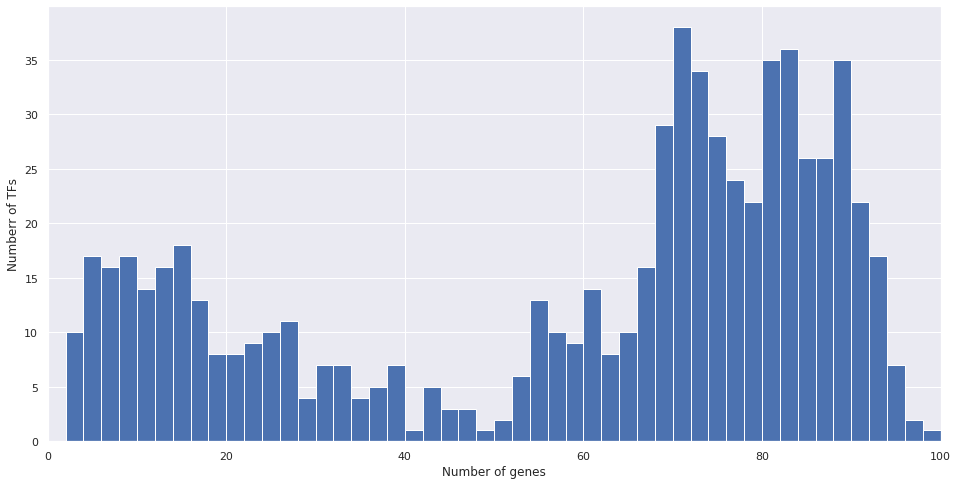

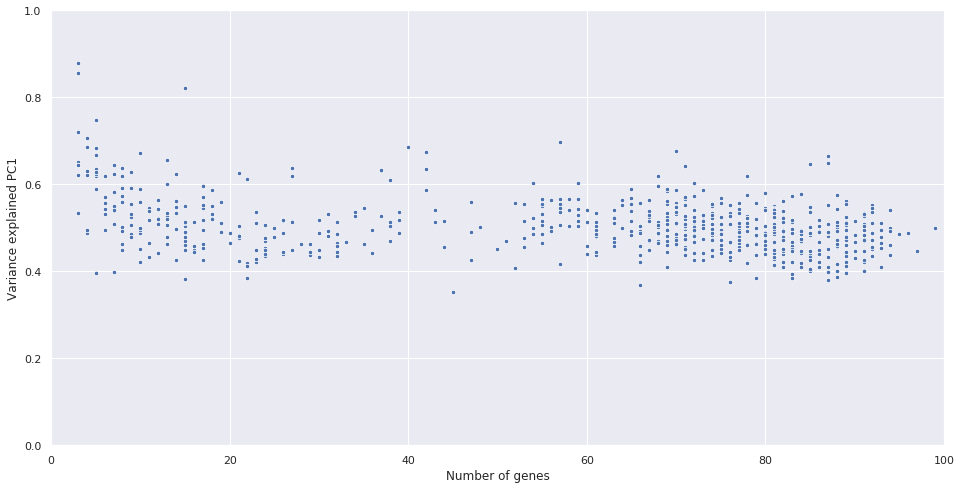

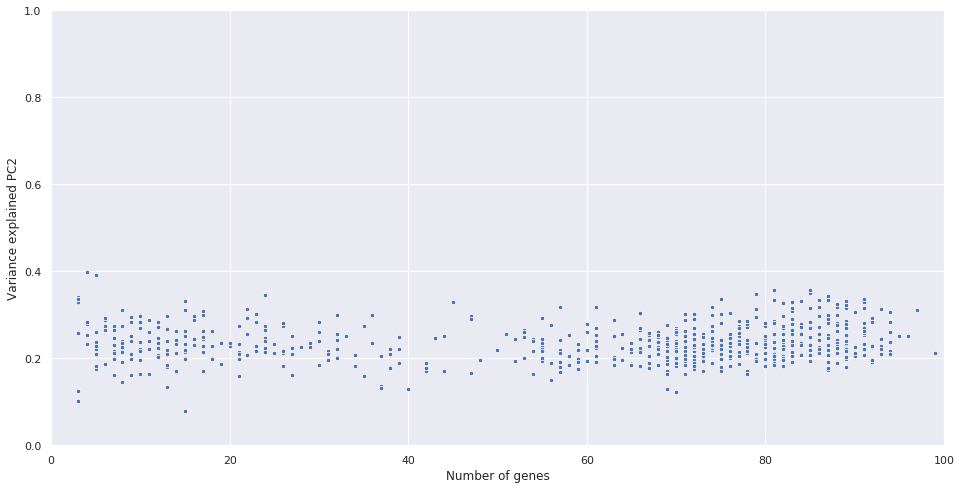

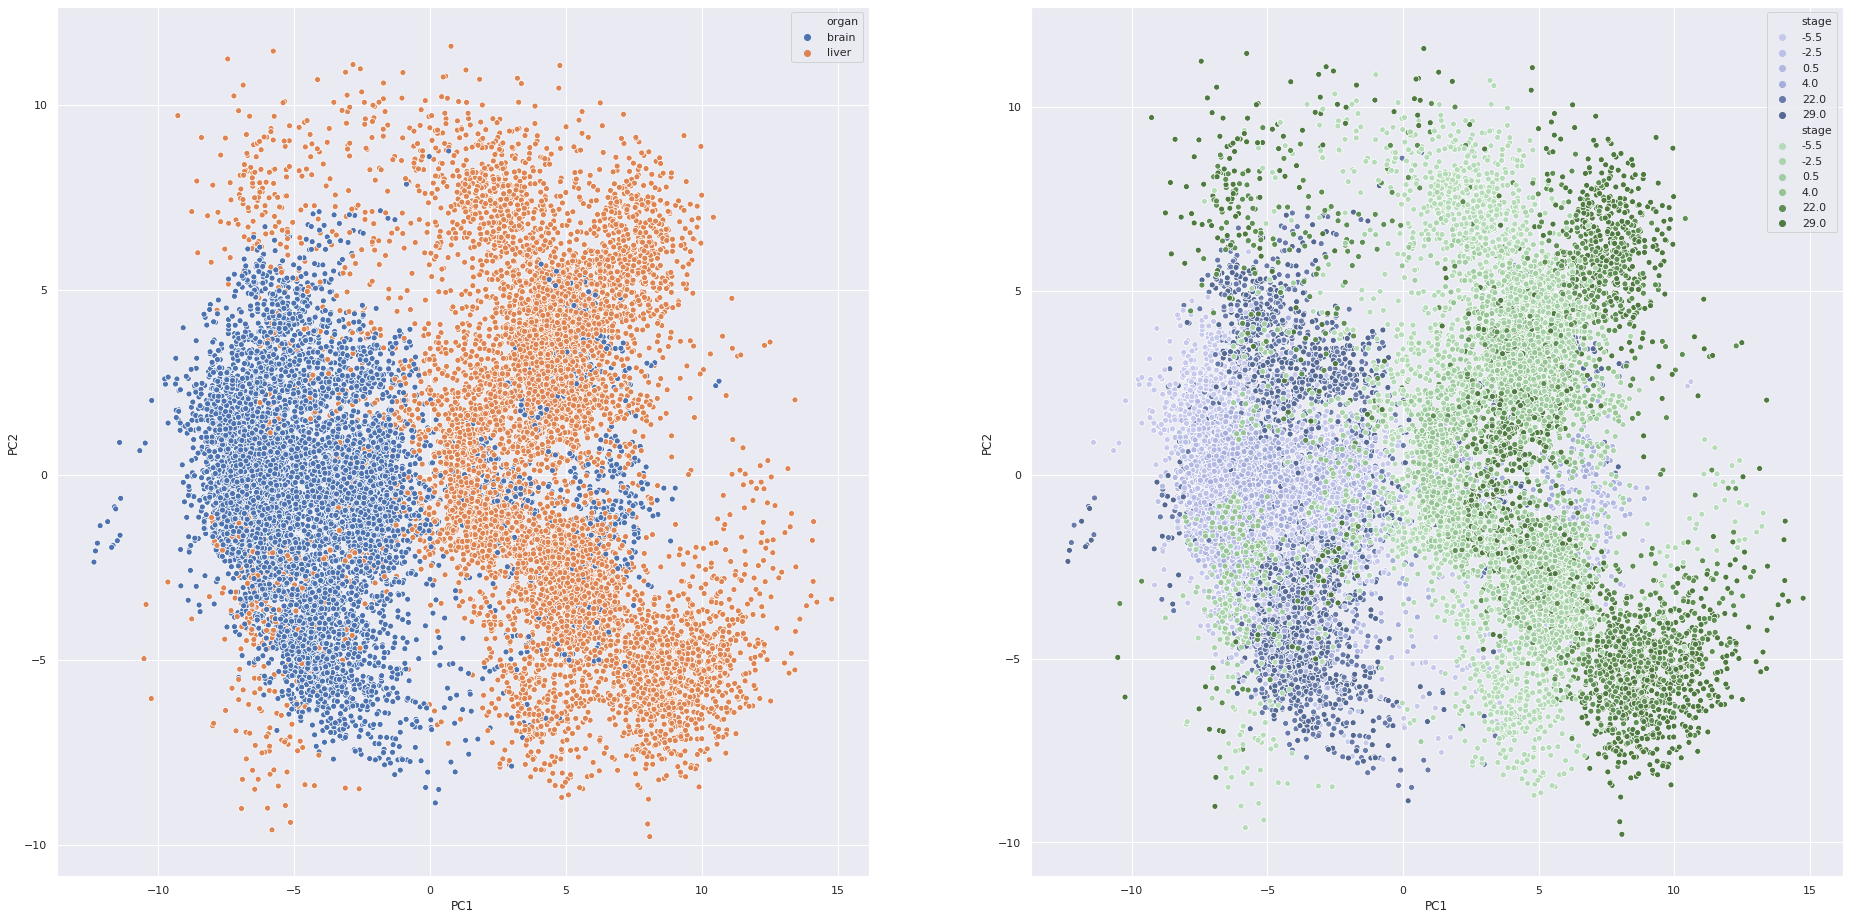

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

In [10]:
[a,b] = datacheck2(10,MACS2=300,MAX=100,n_pc=2)

In [11]:
#Prepare data and perform SVD to test sample behaviour
[dataset, dataset2] = data_set()
expdata = indexing(dataset,dataset2)
expdata = expdata/(expdata.sum()/10**6) #Reads/transcripts per million normalization

print('Here we go...')
lim = expdata.shape[1]*0.25
for gene in expdata.index: #Remove genes for which >25% of samples had no expression
    if expdata.loc[gene,:].tolist().count(0) > lim:
        expdata.drop(gene, inplace=True)
print('Done')

expdata = expdata + 1
logdata = np.log2(expdata)

standardizer = StandardScaler()
data = standardizer.fit_transform(logdata.values.T)

u, s, vh = np.linalg.svd(data.T)
#uu, ss, vvh = np.linalg.svd(expdata-1)

Here we go...
Done


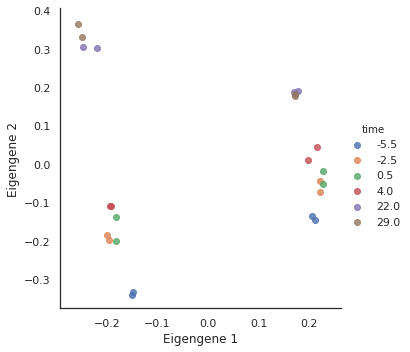

In [80]:
#Plot sample behaviour
sep = 'time'
df = pd.DataFrame(vh[0:2,:].T, columns=['Eigengene 1','Eigengene 2'])
df.loc[:,'organ'] = logdata.columns.get_level_values(0)
df.loc[:,'time'] = logdata.columns.get_level_values(1)
sns.set_style('white')
plot = sns.lmplot(x='Eigengene 1', y='Eigengene 2', data=df, hue=sep, fit_reg=False)

plt.show()
save_fig(plot,'SampleBehaviour',sep)

In [16]:
[dataset, dataset2] = data_set()
print(dataset.shape)
dataset.replace(0,float('NaN'), inplace=True)

display(dataset.dropna().shape)

(32394, 24)


(13513, 24)

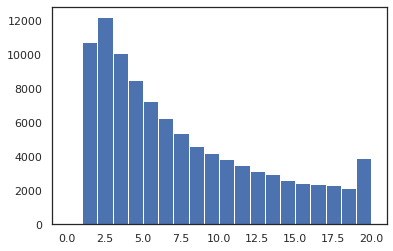

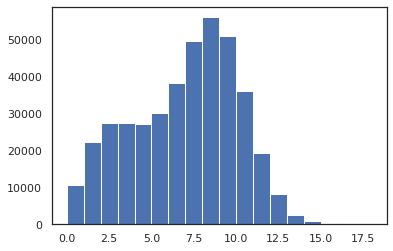

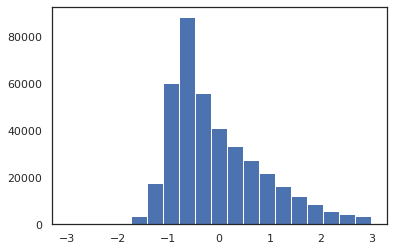

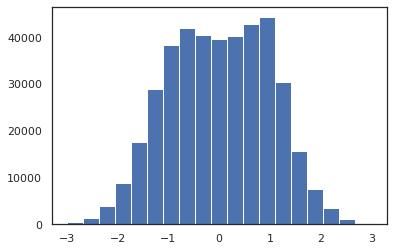

In [109]:
#Plot data distribution
[dataset, dataset2] = data_set()
expdata = indexing(dataset,dataset2)
print('Here we go...')
lim = expdata.shape[1]*0.25
for gene in expdata.index: #Remove genes for which >25% of samples had no expression
    if expdata.loc[gene,:].tolist().count(0) > lim:
        expdata.drop(gene, inplace=True)
print('Done')

expdata = expdata + 1
logdata = np.log2(expdata)

bins1 = np.linspace(0,20,21)
plt.hist(np.concatenate(expdata.loc[:,:].values), bins1)
plt.show()
bins2 = np.linspace(0,18,19)
plt.hist(np.concatenate(logdata.loc[:,:].values), bins2)
plt.show()

zdata1 = pd.DataFrame(data = stats.zscore((expdata-1).values,axis=1), columns=logdata.columns, index=logdata.index)
bins3 = np.linspace(-3,3,20)
plt.hist(np.concatenate(zdata1.loc[:,:].values), bins3)
plt.show()

zdata2 = pd.DataFrame(data = stats.zscore(logdata.values,axis=1), columns=logdata.columns, index=logdata.index)
bins4 = np.linspace(-3,3,20)
plt.hist(np.concatenate(zdata2.loc[:,:].values), bins4)
plt.show()

(13513, 24)


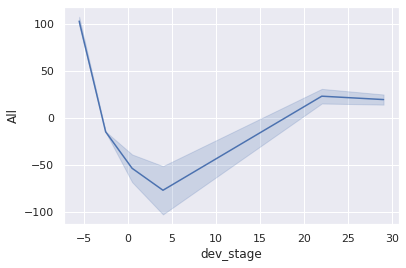

In [42]:
[A,B,C] = testall(n_pc=1, PC=1,organ='brain',remove=1)

(13513, 24)


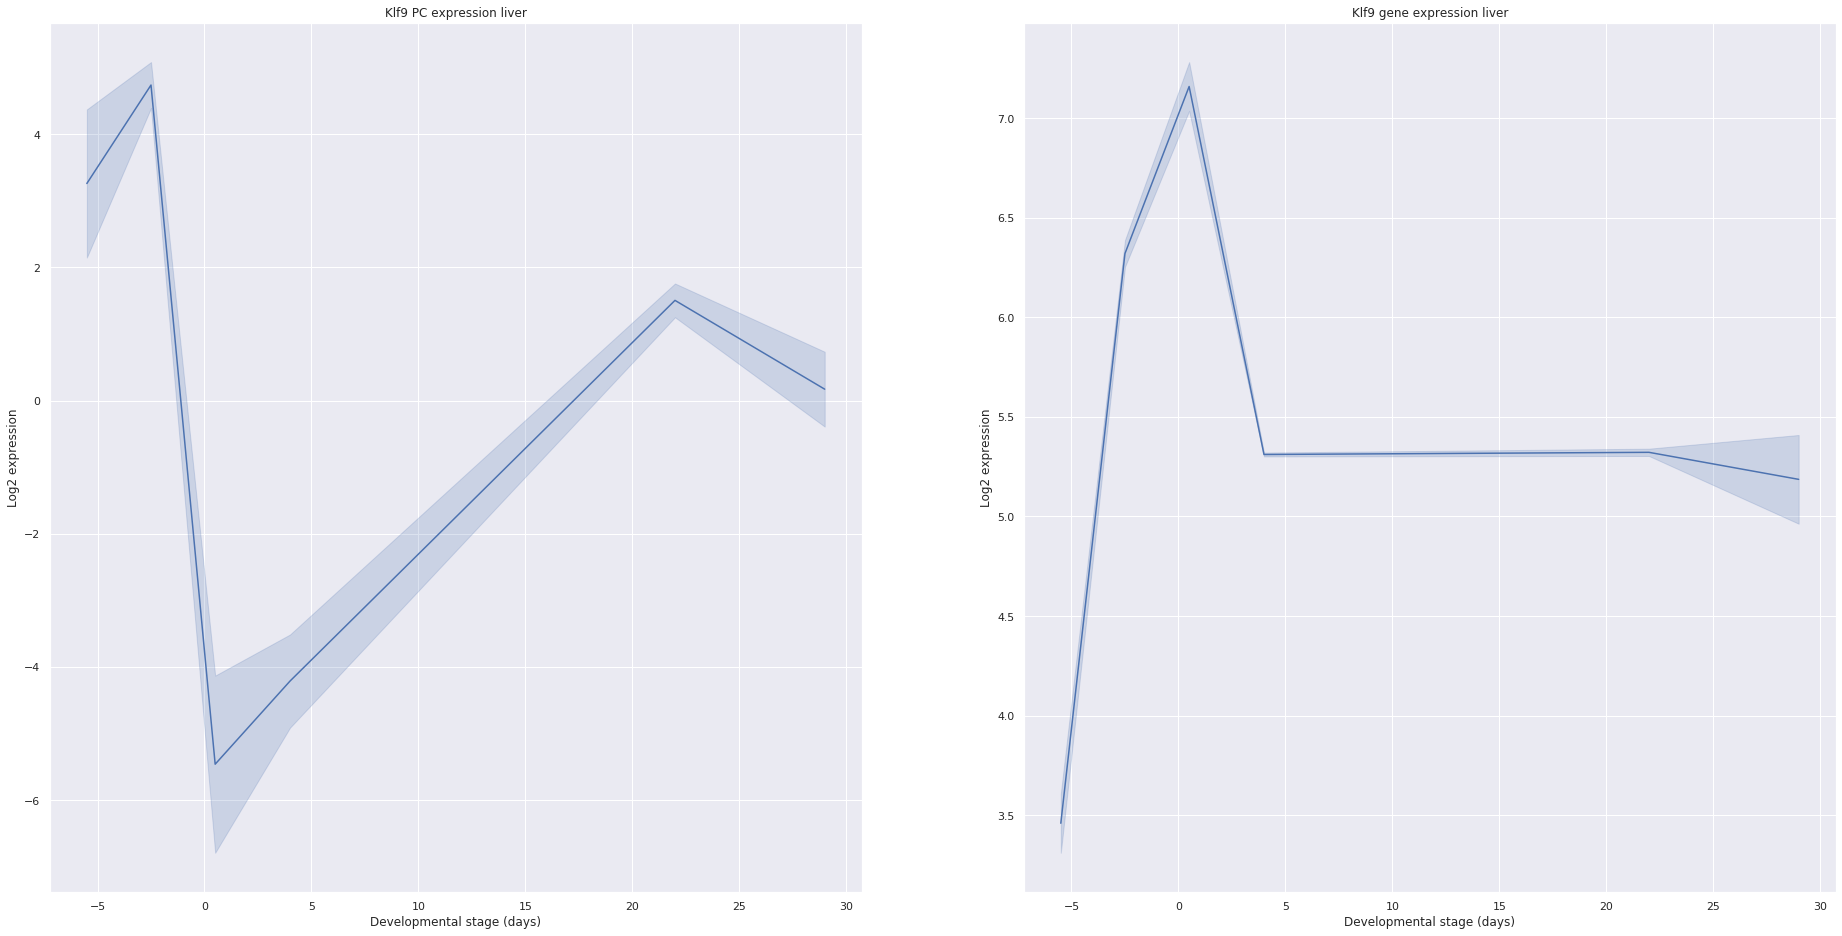

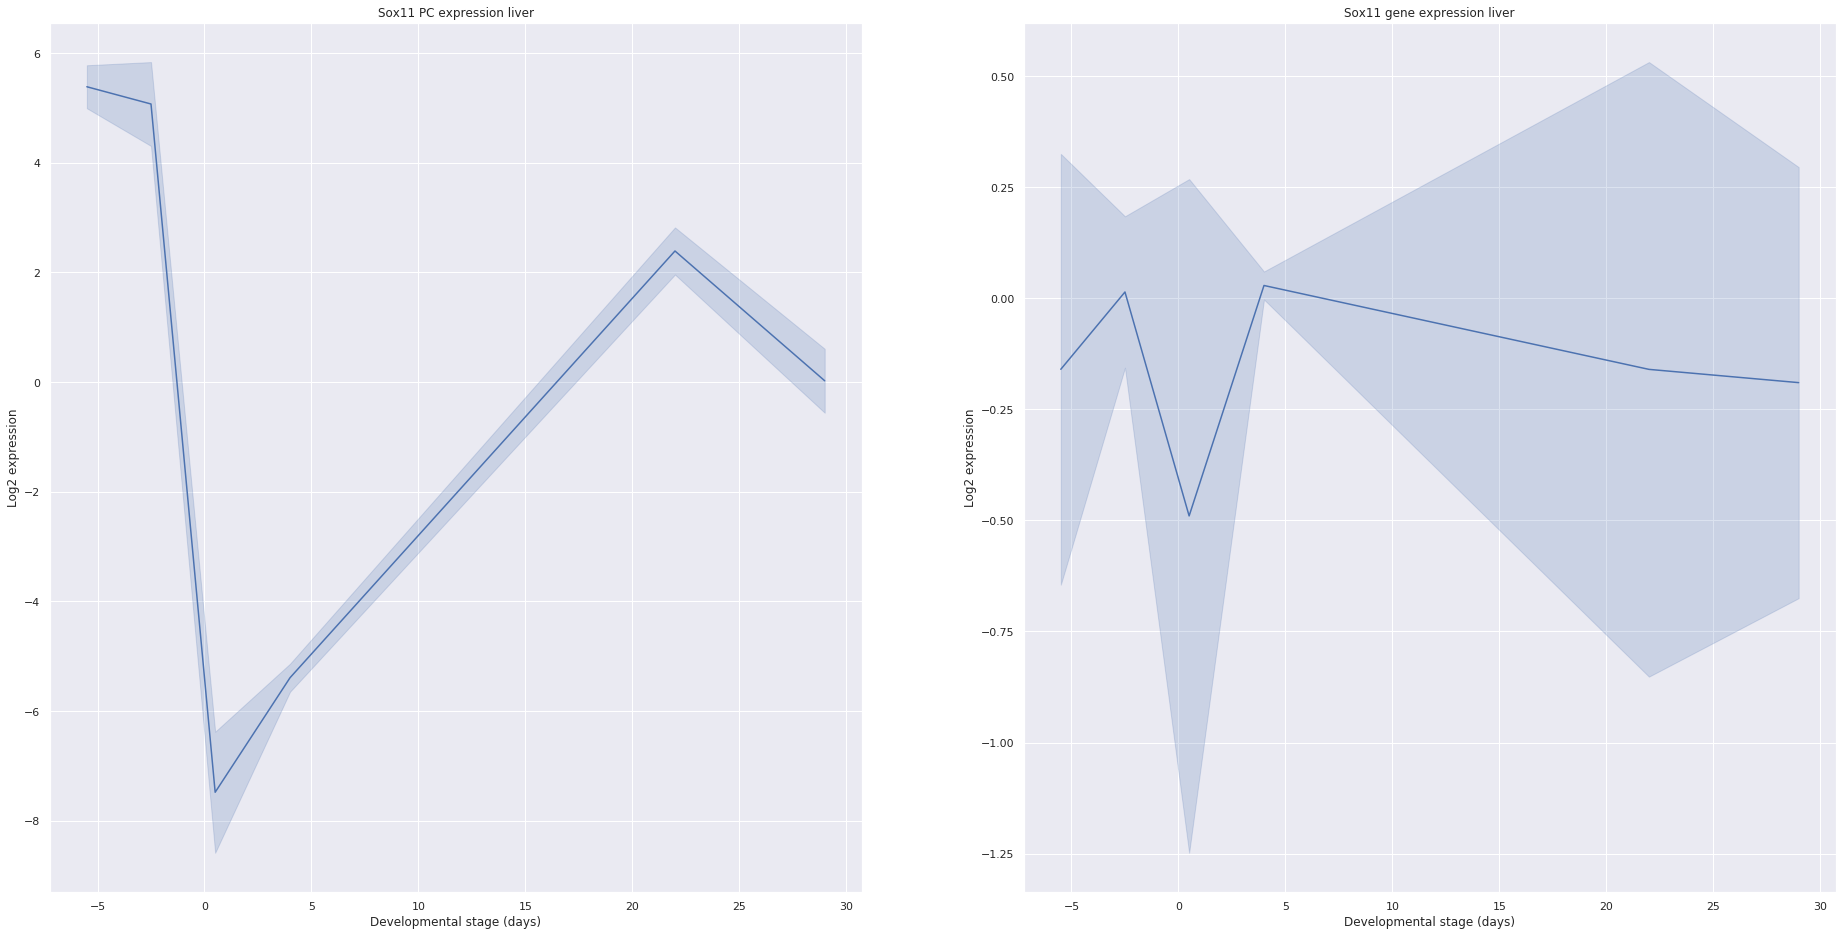

Gene contributions for TF Klf9:


PC1 contribution
Desi1              0.063119
Dcakd              0.058286
Agl                0.057095
Hist1h4n           0.051383
Ndrg1              0.050358
Ctdsp2             0.049303
Lcat               0.047161
Rnf44              0.046677
Xrcc6              0.043883
Mbd6               0.042529
Hist1h4m           0.040763
Armc7              0.039540
Nectin2            0.036089
Casp3              0.035904
Smpd4              0.031847
Anxa2              0.030749
Txndc11            0.026638
Acads              0.025548
Cage1              0.023497
Fam104a            0.019784
Nudt6              0.019202
Hexb               0.018863
Klf13              0.016293
Ilrun              0.016193
Kpna1              0.012941
Sccpdh             0.012667
Arhgap28           0.011843
Unc50              0.011685
Fbxw8              0.011095
D11Wsu47e          0.007901
Pole4              0.007759
Tfip11             0.004760
Zfp622             0.004162
Psmb10             0.003817
Ccdc90b            0.003738
Aida               0.003206
Anapc7             0.002893
Smyd5              0.002358
Smarcb1            0.002285
Rpl37rt            0.001393
Brox               0.000992
Arid4a             0.000971
Cdhr2              0.000938
Riok1              0.000875
Spata5             0.000441
Coa5               0.000221
Rps29              0.000141
Fam13b             0.000126
Slc6a9             0.000082
Prmt2              0.000006

Variance explained by PC1 for TF Klf9: 


0.28994629875108535

Gene contributions for TF Sox11:


PC1 contribution
Etv6         3.786918e-02
Ralgds       3.549172e-02
Pex16        3.496025e-02
Hsph1        3.366408e-02
Nr1d1        3.333696e-02
...                   ...
Mboat2       4.205491e-05
Cdk2ap1      9.107179e-06
Plxnb1       8.278017e-06
Rala         4.134890e-06
Nradd        2.121975e-07

[91 rows x 1 columns]

Variance explained by PC1 for TF Sox11: 


0.27099958673084396

In [34]:
[a,b,c] = main_0(10,MACS2=300,MAX=100,n_pc=1,PC=1,organ='liver',which='Top',remove=1)

Here we go...
Done
(16984, 24)


(12, 14)

(12, 70)

Uhrf1 has less than 3 genes associated with it and is therefore disregarded.


(12, 5)

(12, 60)

(12, 15)

(12, 75)

(12, 93)

(12, 85)

(12, 19)

ValueError: Could not interpret input 'Uhrf1'

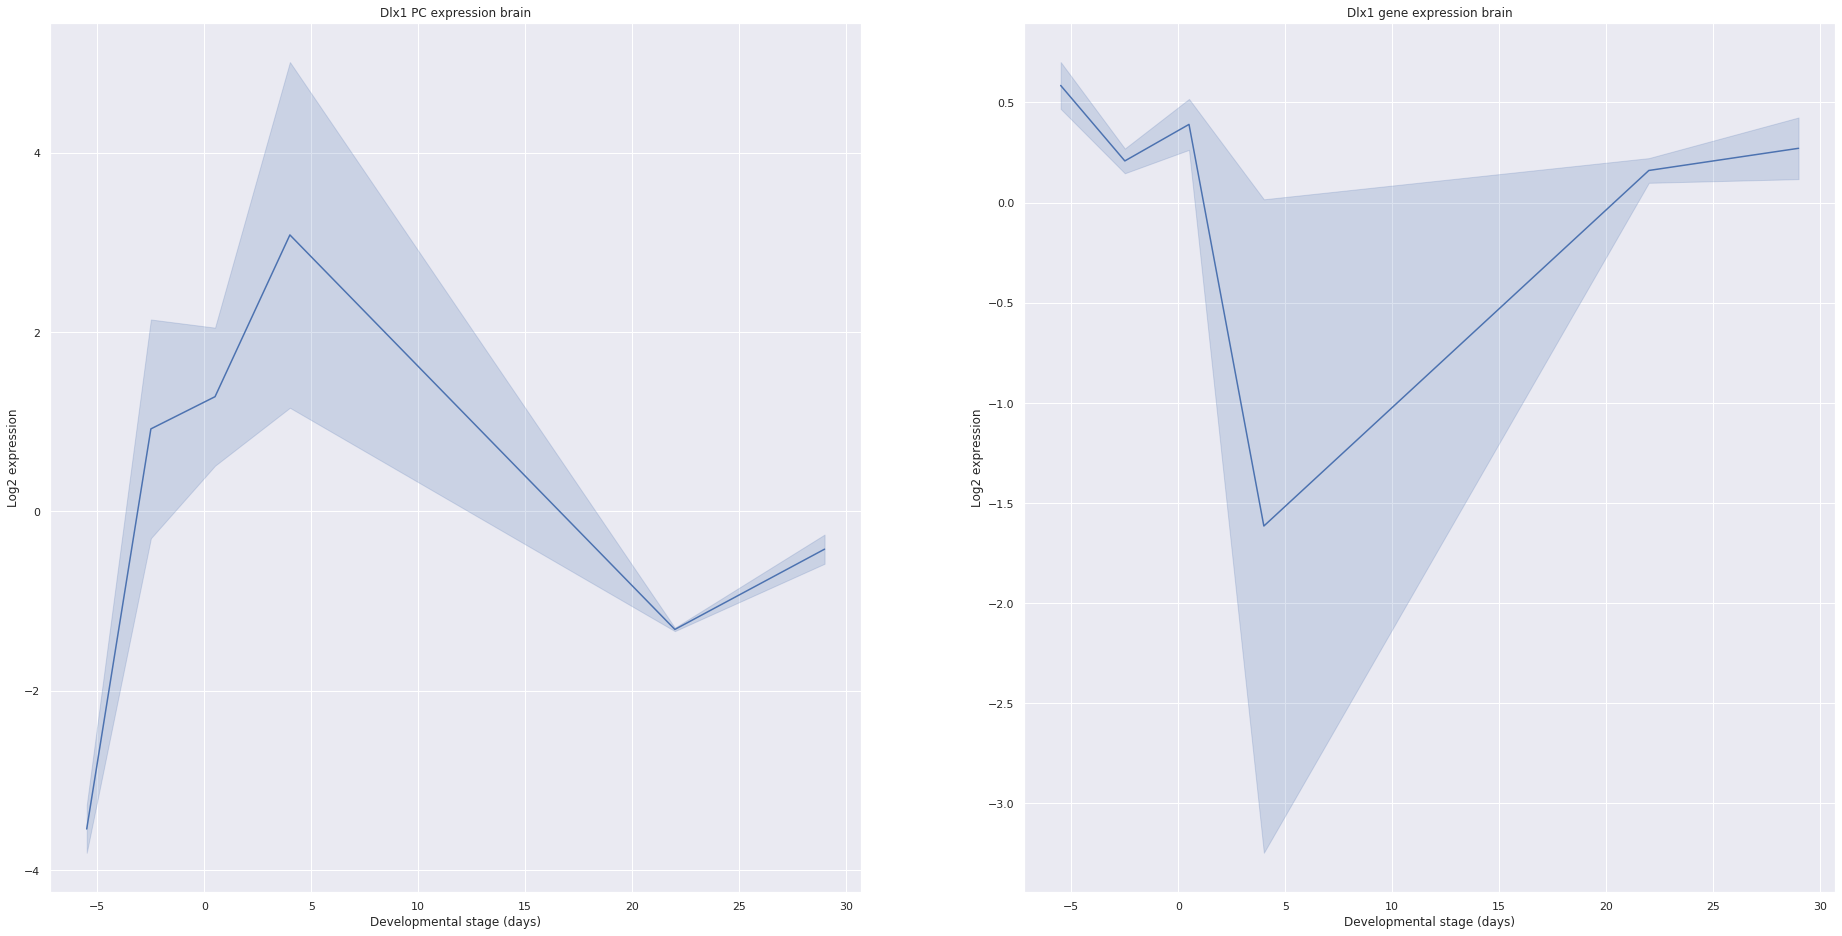

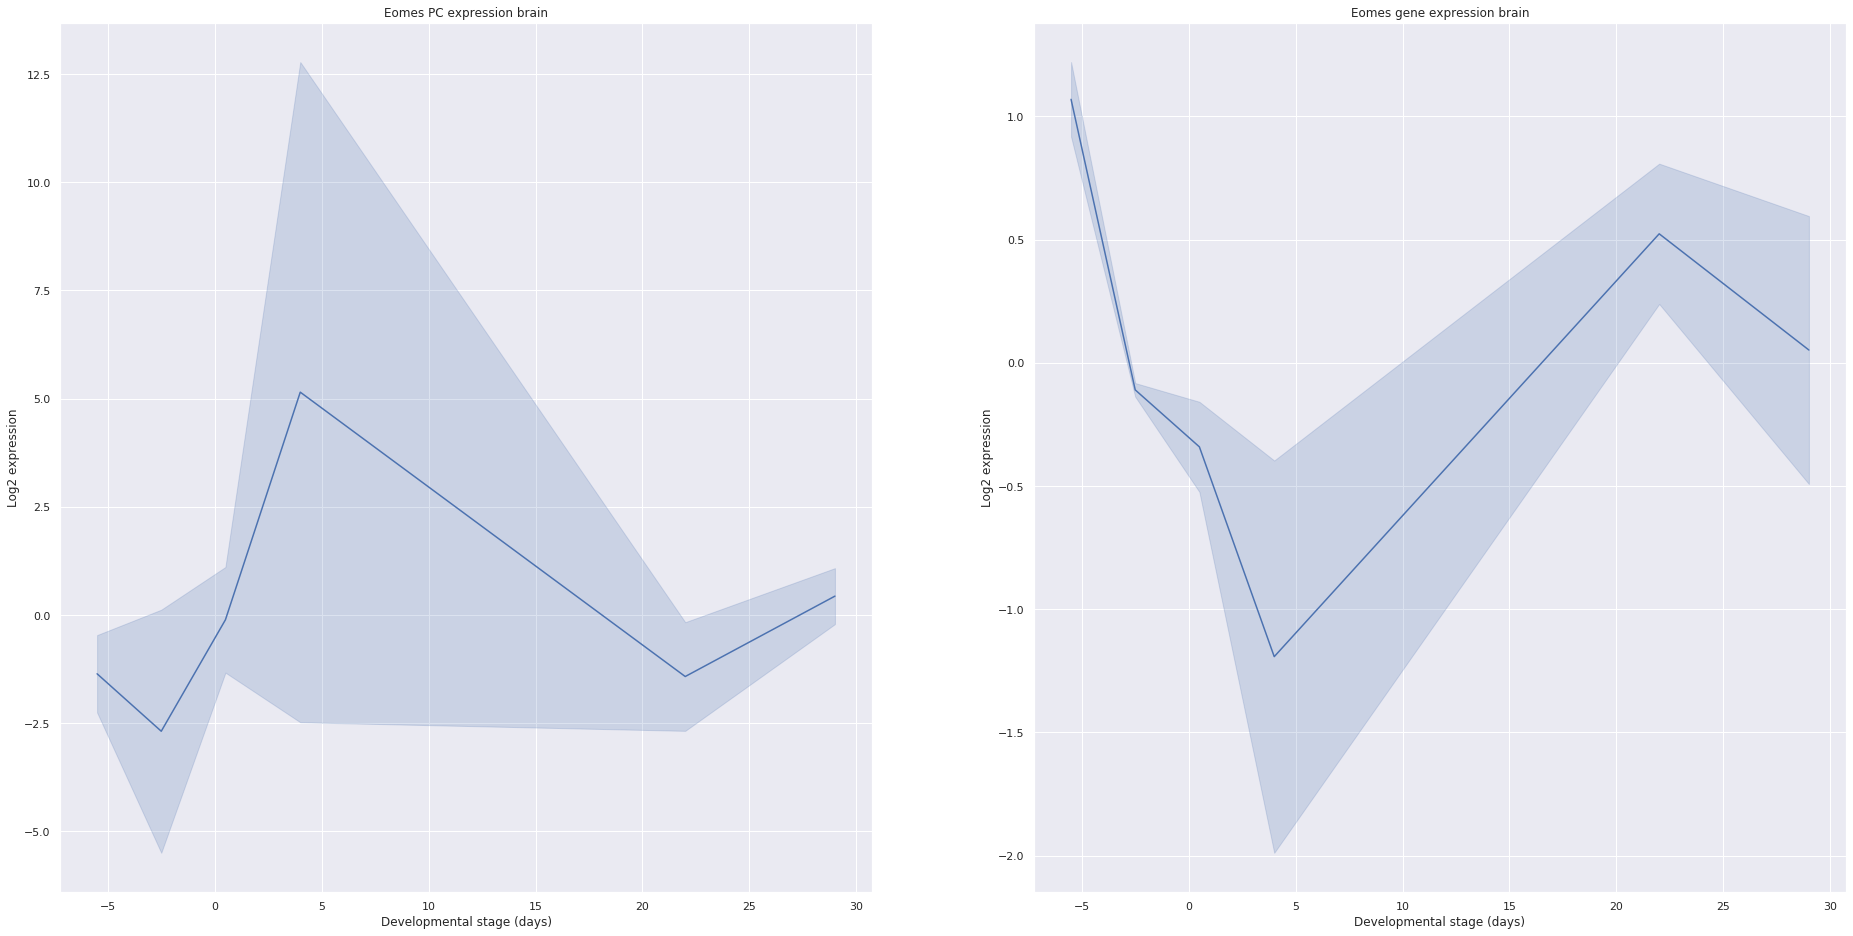

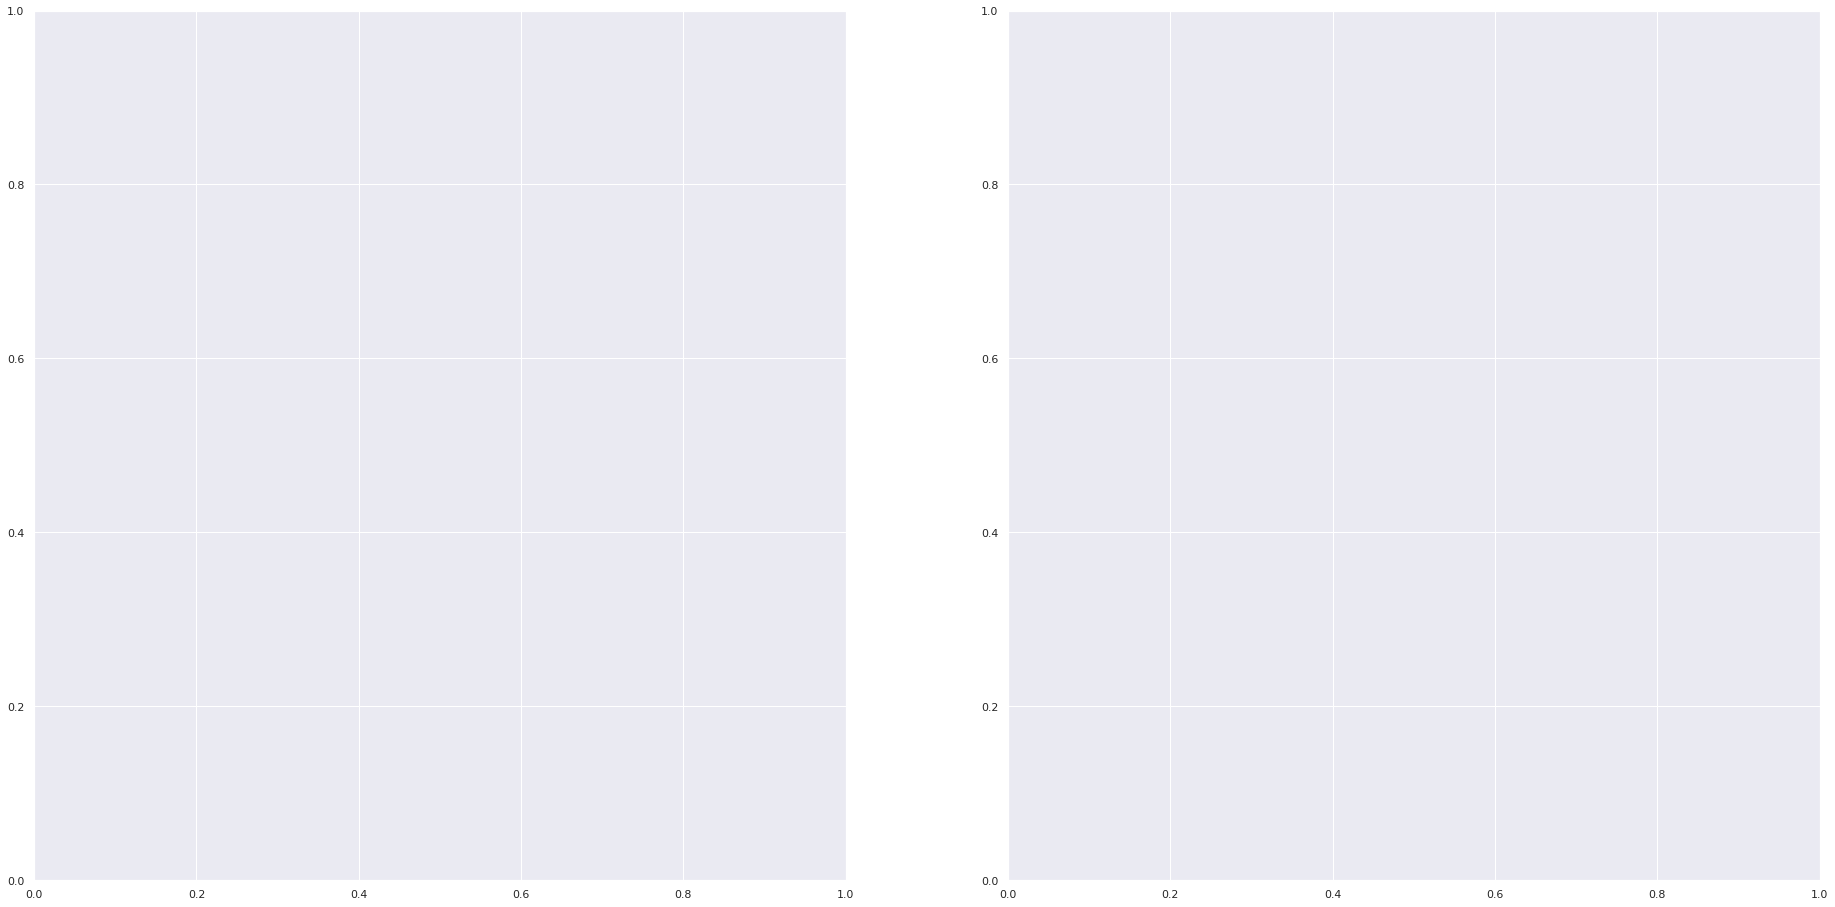

In [7]:
#All components
[a,b,c] = main2(10,MACS2=300,MAX=100,n_pc=3,PC=1,organ='brain',which='Top')

In [ ]:
DICT = Bigdict(10)
for MACS2 in [300,500,700]:
    for MAX in [100,300,500]:
        TF_targets_dict(DICT,MACS2,MAX,10)

organ        liver        brain         liver         brain        liver  \
dev_stage    -5.5   -5.5  -5.5  -5.5    -2.5    -2.5  -2.5  -2.5    0.5    
Symbol                                                                     
Gnai3         4800   1646  2510  1424    4779    3478  1694  2512   2481   
Pbsn             0      0     0     0       0       0     0     0      0   
Cdc45          984    337   163   108     549     490    63    90    420   
H19          77631  31553  4113  1862  182270  140922  1289  3352  79202   
Scml2           72     25    85    54      48      38    63   117     34   
...            ...    ...   ...   ...     ...     ...   ...   ...    ...   
Vmn1r-ps47       0      0     0     0       0       0     0     0      0   
Gm22396          0      0     0     0       0       0     0     0      0   
Gm22394          0      0     0     0       1       0     0     0      0   
Vmn1r-ps147      0      0     0     0       0       0     0     0      0   
Methig1          0      0     0     0       0       4     0     0      1   

organ               ... brain       liver       brain       liver       brain  \
dev_stage     0.5   ...  4.0   4.0   22.0  22.0  22.0  22.0  29.0  29.0  29.0   
Symbol              ...                                                         
Gnai3         1138  ...  2429  1502  2125  1974  1153  1409  1543  1470  1937   
Pbsn             0  ...     0     0     0     0     0     0     0     0     0   
Cdc45          202  ...    99   123    98   110    41    40    27    32    73   
H19          72111  ...   403   996  2219  2385    34    73   151    71    47   
Scml2           17  ...    92    63    17     5    13    17     6     2    26   
...            ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
Vmn1r-ps47       0  ...     0     0     0     0     0     0     0     0     0   
Gm22396          0  ...     0     0     0     0     0     0     0     0     0   
Gm22394          0  ...     0     0     0     0     0     0     0     0     0   
Vmn1r-ps147      0  ...     0     0     0     0     0     0     0     0     0   
Methig1          0  ...     0     0     0     0     0     0     0     0     0   

organ              
dev_stage    29.0  
Symbol             
Gnai3         856  
Pbsn            0  
Cdc45          29  
H19            29  
Scml2           9  
...           ...  
Vmn1r-ps47      0  
Gm22396         0  
Gm22394         0  
Vmn1r-ps147     0  
Methig1         0  

[32394 rows x 24 columns]

Dataset contains 694 TFs
Dataset contains 0 TF(s) with only a single gene


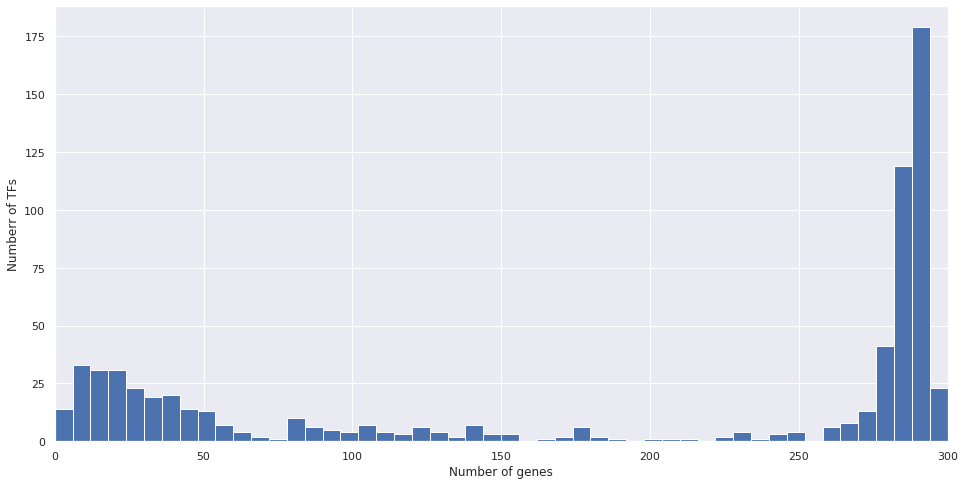

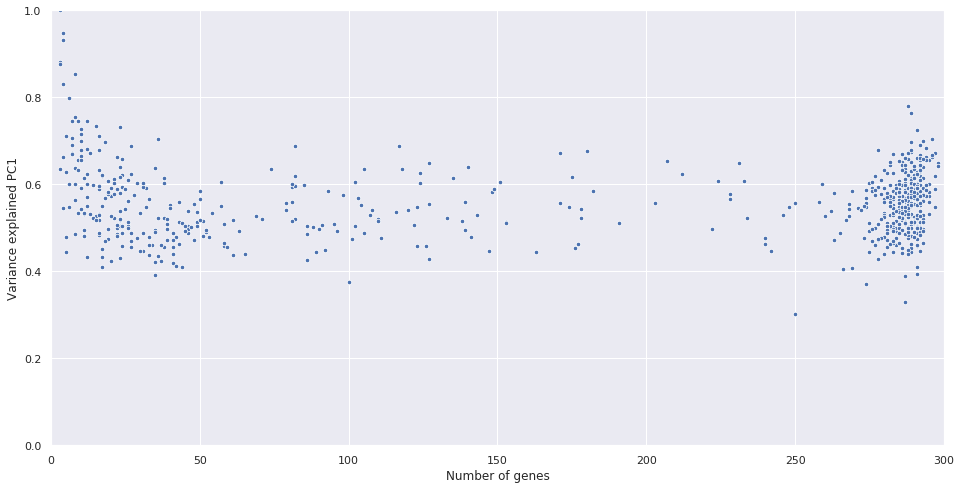

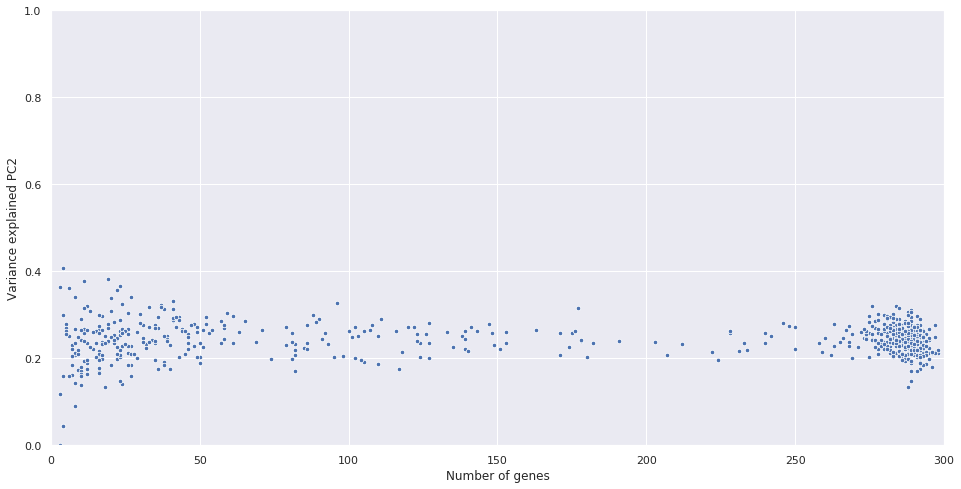

PC1       PC2  stage
0  -2.906529  0.704332   -5.5
1   0.932319  2.880924   -5.5
2  -2.137053  0.495952   -2.5
3  -1.434418  0.328252   -2.5
4  -1.196534 -0.592267    0.5
..       ...       ...    ...
7   0.366943 -0.171035    4.0
8  -0.366671  2.198302   22.0
9  -1.029158  3.446587   22.0
10 -1.976298  1.029578   29.0
11 -3.120863  1.985876   29.0

[8328 rows x 3 columns]

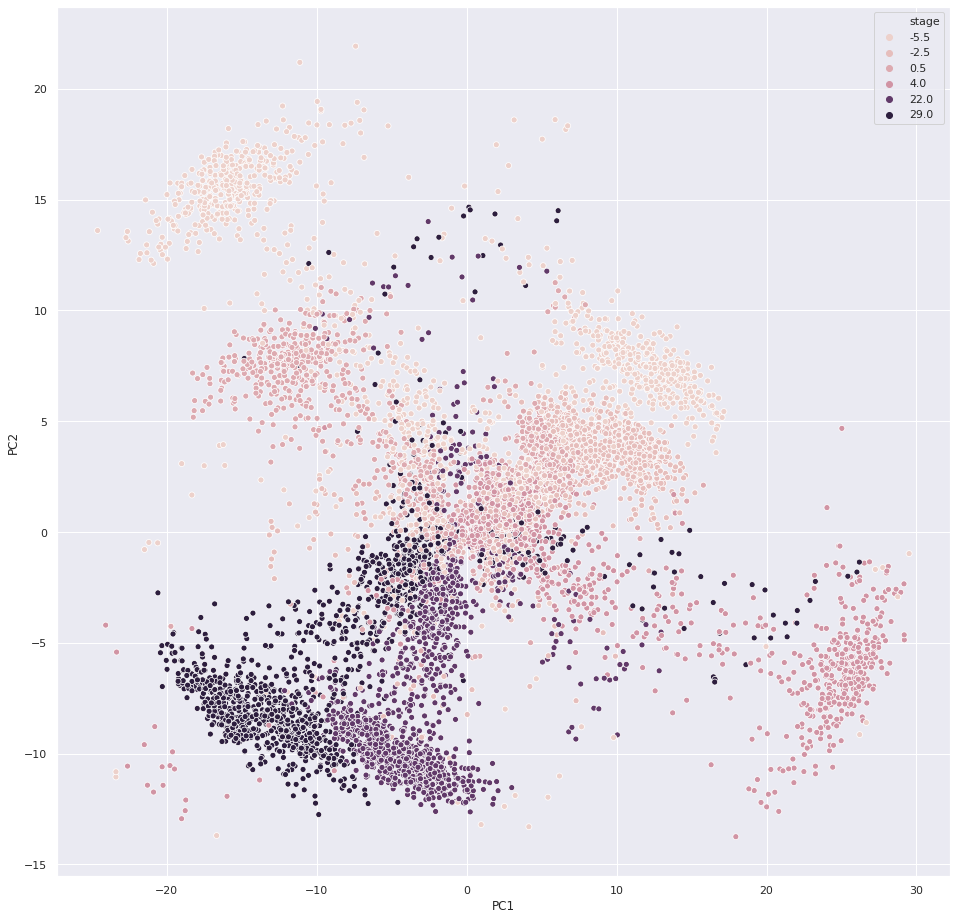

In [30]:
[a,b] = datacheck2(10,300,300,'liver')

Dataset contains 694 TFs
Dataset contains 0 TF(s) with only a single gene


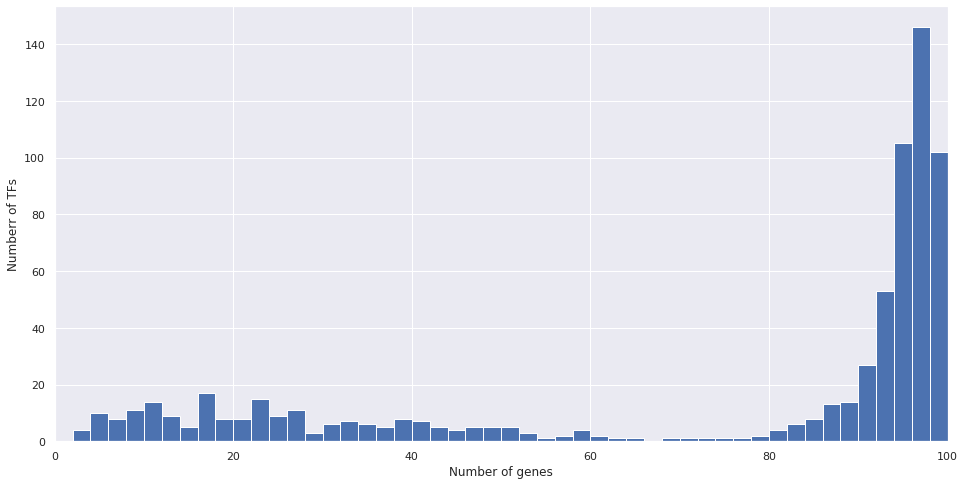

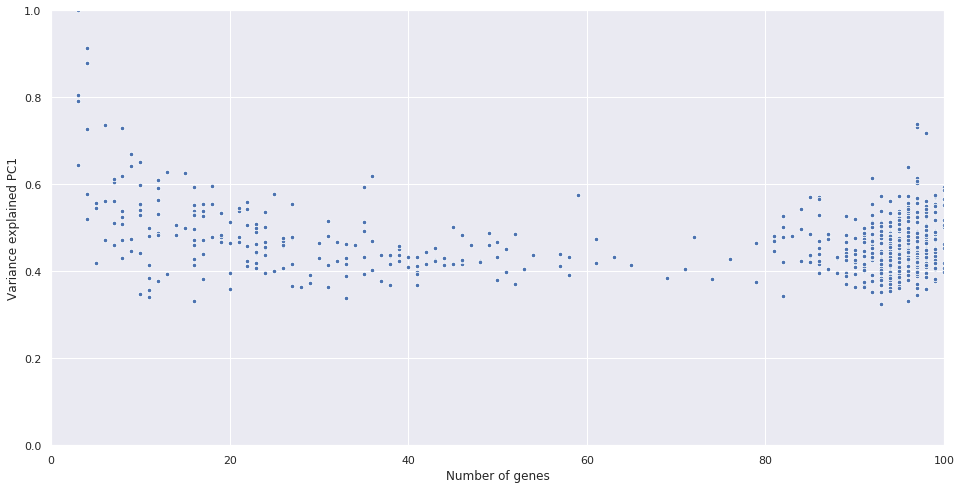

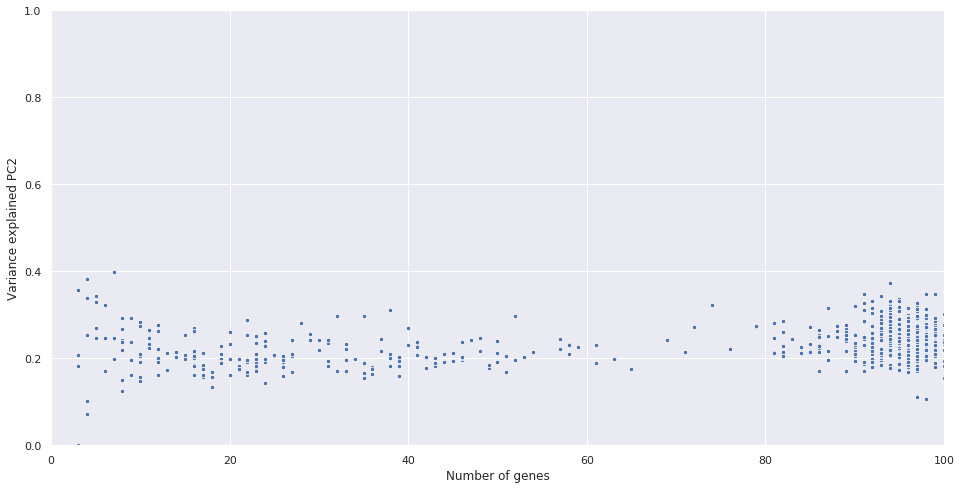

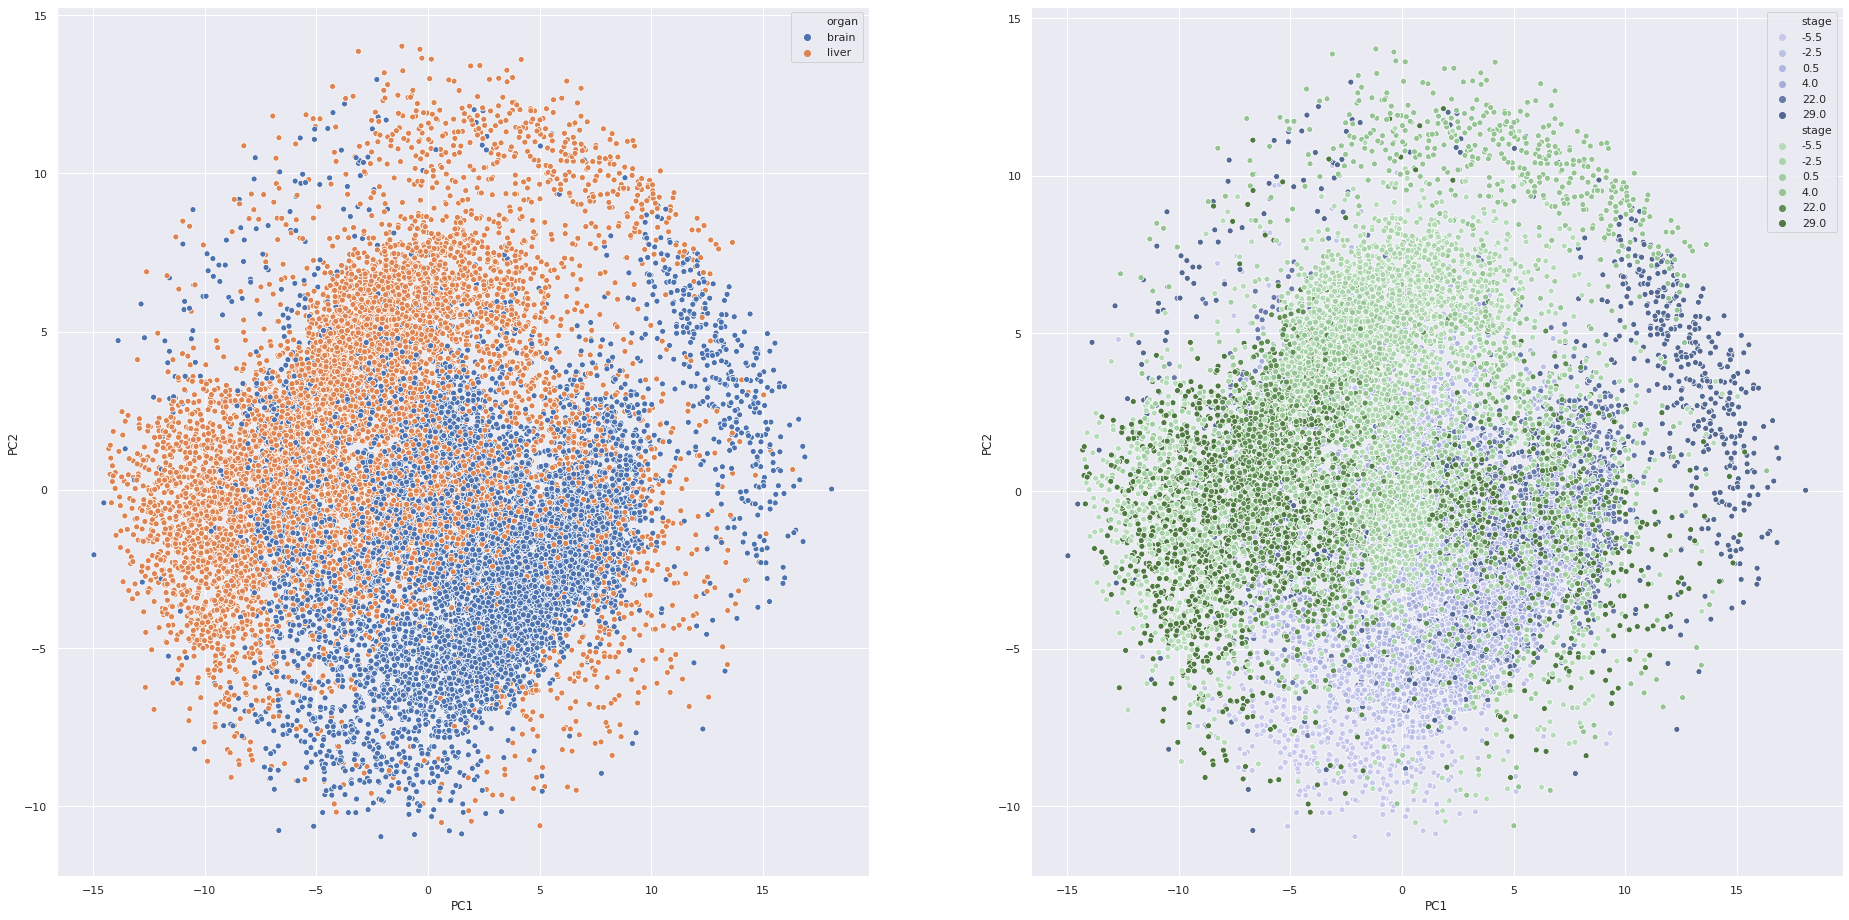

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [16]:
[a,b] = datacheck2(10,300,100)

Dataset contains 699 TFs
Dataset contains 0 TF(s) with only a single gene


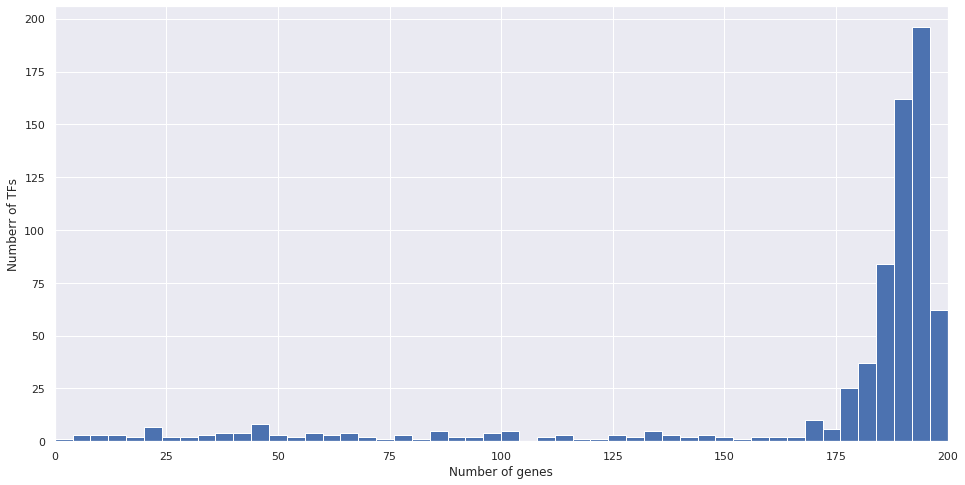

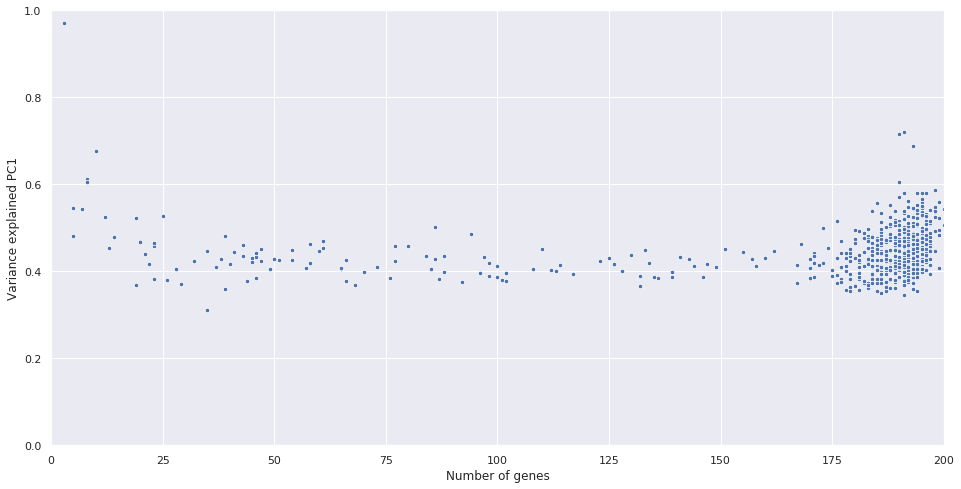

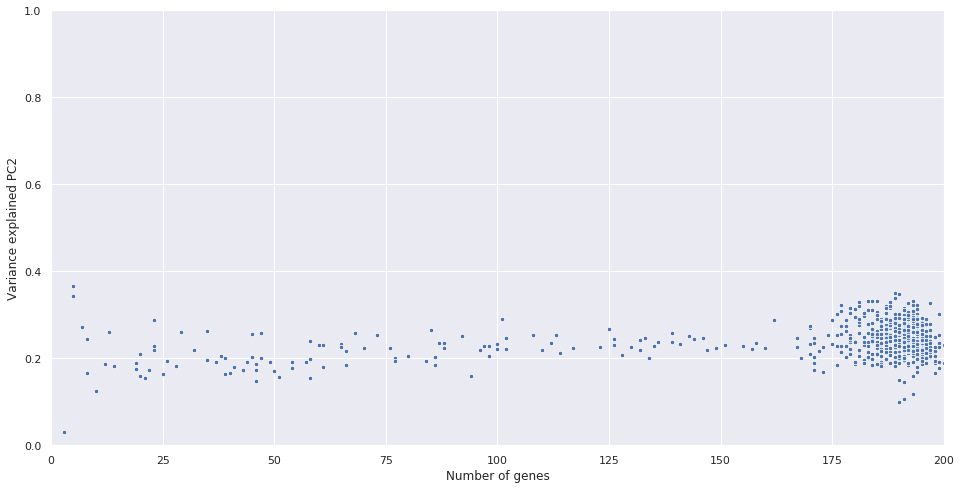

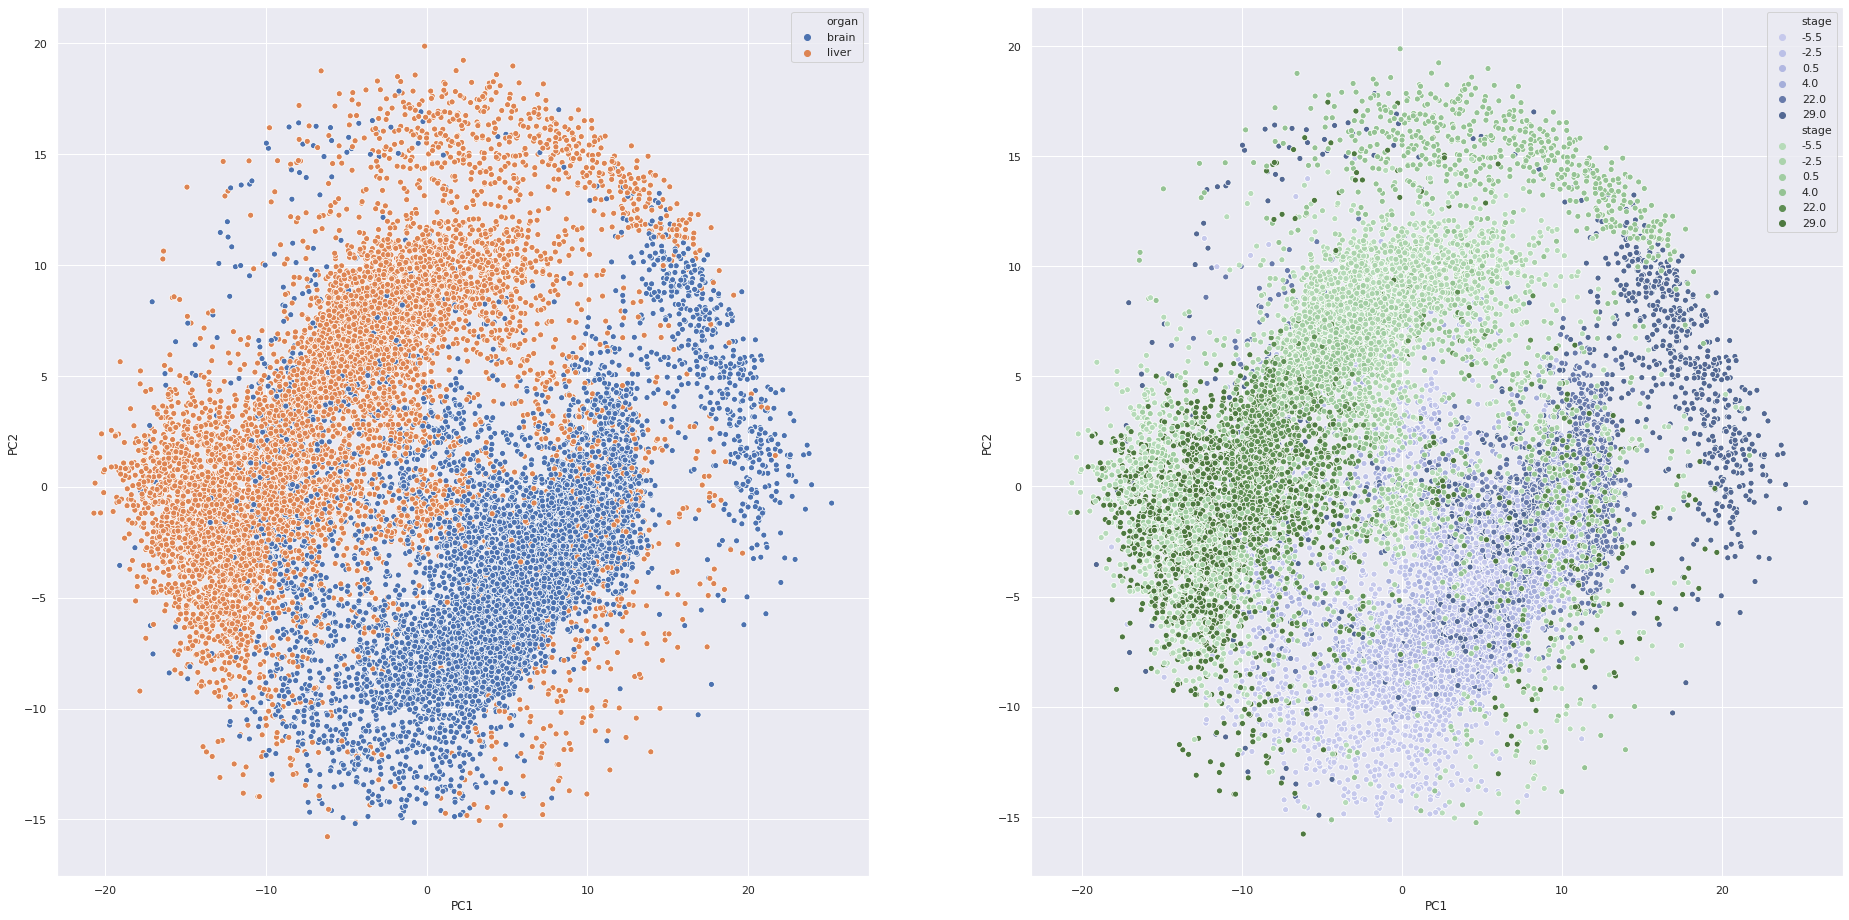

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [105]:
[res, cont] = datacheckTOP(10,200)

/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: Pe

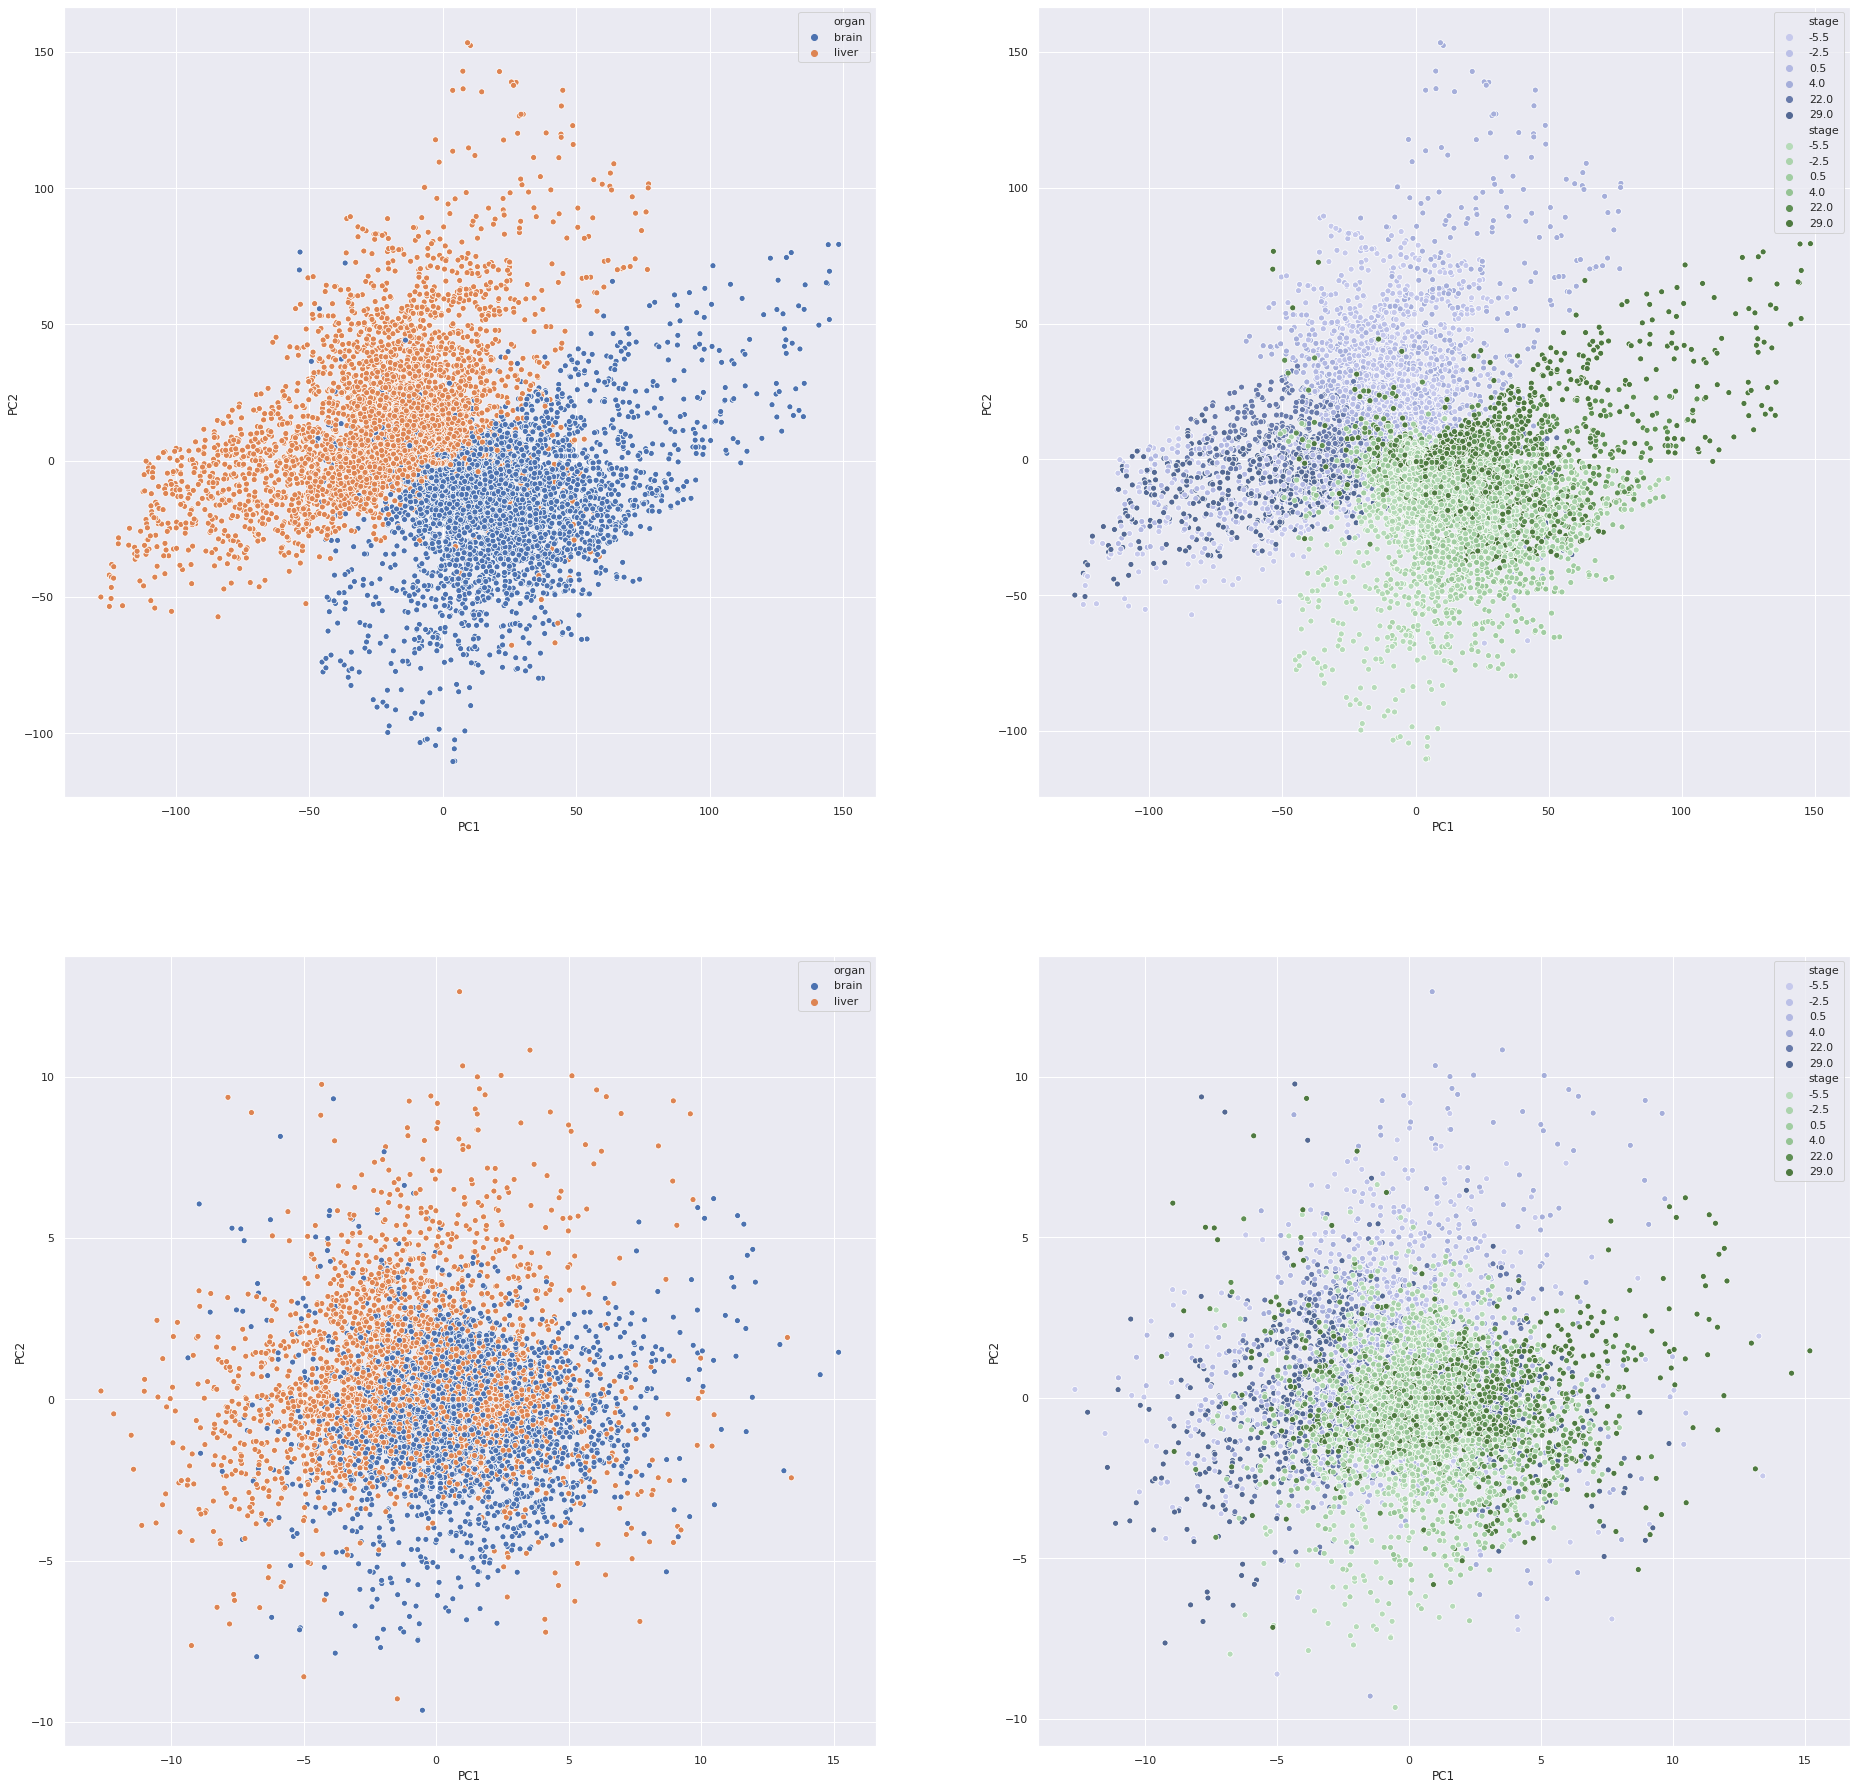

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [24]:
PCcheck(10,700,100)

## Old/unused code

In [8]:
def gene_sets_TOP(kbp, MAX):
    '''
    Fetch data on which genes may be regulated by each TF.
    '''
    # Read csv with all all TFs and urls to files with their target genes
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')

    #Read csv with TFs and their target genes. If not available, fetch the data and create a csv
    try: 
        TF_gene_sets = pd.read_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(kbp)+'kbp.tsv', sep='\t', index_col='Antigen', converters={'Genes': lambda x: x.strip('[]').replace("'","").split(', ')})
    except FileNotFoundError:
        TF_gene_sets = TFs_targets_TOP(kbp, MAX, chip)
        
    return TF_gene_sets

def TFs_targets_strict(kbp, MACS2, chip): 
    '''
    Function for creating csv with all TFs and a strict selection of their potential target genes. For each TF, 
    it identifies urls for target genedata, fetches the info and puts genes with a high enough MACS2 and STRING
    binding score into a list that is then converted to a dataframe as output
    '''
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                TF_gene_set = pd.read_csv(url, sep='\t', index_col='Target_genes') #For a specific TF, read csv from url as a dataframe
                genes = TF_gene_set.loc[(TF_gene_set > MACS2).sum(axis=1)>0,:].index.tolist() #Take the contents of column 'Target_genes' and puts it into a list for rows with a value above set MACS2 threshold
                TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                genes = []
                TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.drop(TF_gene_sets[TF_gene_sets.Genes == '[]'].index, inplace=True)
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_'+str(kbp)+'_'+str(MACS2)+'.tsv', sep='\t')
    return TF_gene_sets


def TFs_targets_TOP(kbp, MAX, chip): 
    '''
    Function for creating csv with all TFs and a strict selection of their potential target genes. For each TF, 
    it identifies urls for target genedata, fetches the info and puts up to a specified number of genes into a
    list. MACS2 scores are averaged across each sample type and genes with the highest MACS2 score, 
    considering all sample types, are selected for the list. The list is then coverted to a dataframe as
    output.
    '''
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                TF_gene_set = pd.read_csv(url, sep='\t', index_col='Target_genes').iloc[:,1:-1] #For a specific TF, read csv from url as a dataframe
                col = list(TF_gene_set.columns)
                for i in range(len(col)):
                    col[i] = col[i].split('|',1)[1]
                TF_gene_set.columns = col
                TF_set = pd.DataFrame(index=TF_gene_set.index, columns=set(col))
                for sample in TF_set.columns:
                    TF_set[sample] = TF_gene_set.loc[:,[sample]].mean(axis=1)
                TF_set['Max'] = TF_set.max(axis=1)
                genes = TF_set.nlargest(n=MAX, columns='Max').index.tolist()
                TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                genes = []
                TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.drop(TF_gene_sets[TF_gene_sets.Genes == '[]'].index, inplace=True)
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(kbp)+'kbp.tsv', sep='\t')
    return TF_gene_sets

def main_porch(kbp, MACS2,genelim):
    '''
    Main function for running the primary experiment, but using porch
    '''
    #Fetch data of which genes may be regulated by specific TFs, longitudinal mRNA expression data, and sample classification data
    TF_gene_sets = gene_sets_porch (kbp, MACS2)
    for TF in TF_gene_sets.index:
        if len(TF_gene_sets.loc[TF,:][0])>genelim:
            TF_gene_sets.drop(TF,inplace=True)
    [dataset, dataset2] = data_set()
    #Set index for expression data and log2 transform it
    expdata = indexing(dataset,dataset2)
    [PCA_results, untested] = porch(expdata, TF_gene_sets.reset_index(), gene_column='Genes', set_column='Antigen')

    return PCA_results, untested   